# Imports

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from neighbors import NNMF_sgd
from pymer4.models import Lmer
from pymer4.utils import _sig_stars

from fit_all_models import prepare_data
from lib import (
    plot_overall_results,
    plot_results,
    plot_timeseries_predictions,
    prepare_df_for_plotting,
)

sns.set_context("talk", font_scale=1.2)
sns.set_style("whitegrid")
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Avenir"]

In [2]:
base_dir = Path("..")
data_dir = base_dir / "data"
fig_dir = base_dir / "figures"
analysis_dir = base_dir / "analysis"

# IAPS

In [46]:
iaps = pd.read_csv(analysis_dir / "iaps_user_model_comparison.csv")
iaps_plot = prepare_df_for_plotting(iaps, "iaps", metric="rmse", df_type="user", normalize=100)

## Overall

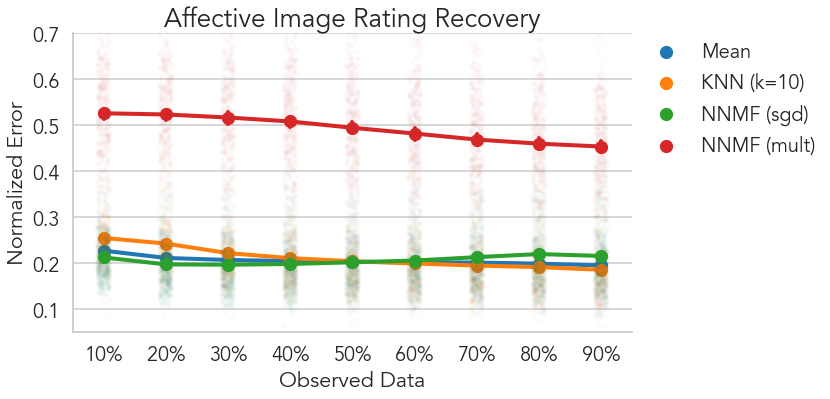

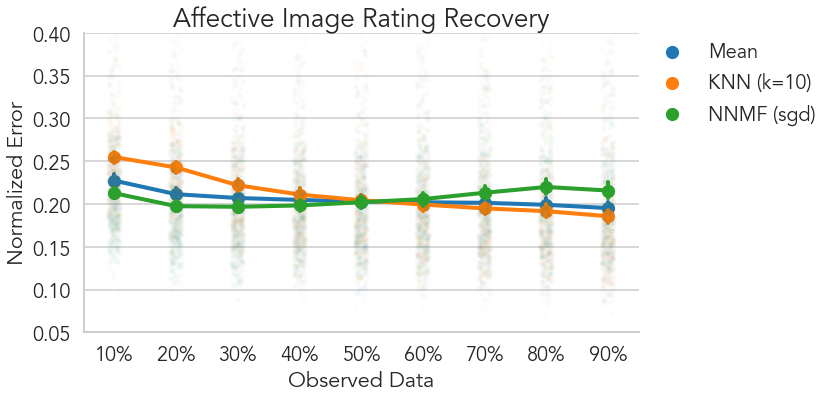

In [5]:
# With NNMF_mult
plot_overall_results(
    iaps_plot,
    title="Affective Image Rating Recovery",
    hide_nmf_m=False,
    save=fig_dir / "iaps" / "overall",
    ylim=(0.05, 0.7),
)
# Without NNMF_mult
plot_overall_results(
    iaps_plot,
    title="Affective Image Rating Recovery",
    hide_nmf_m=True,
    save=fig_dir / "iaps" / "overall_no_m",
    ylim=(0.05, 0.4),
)

### By Emotion plots

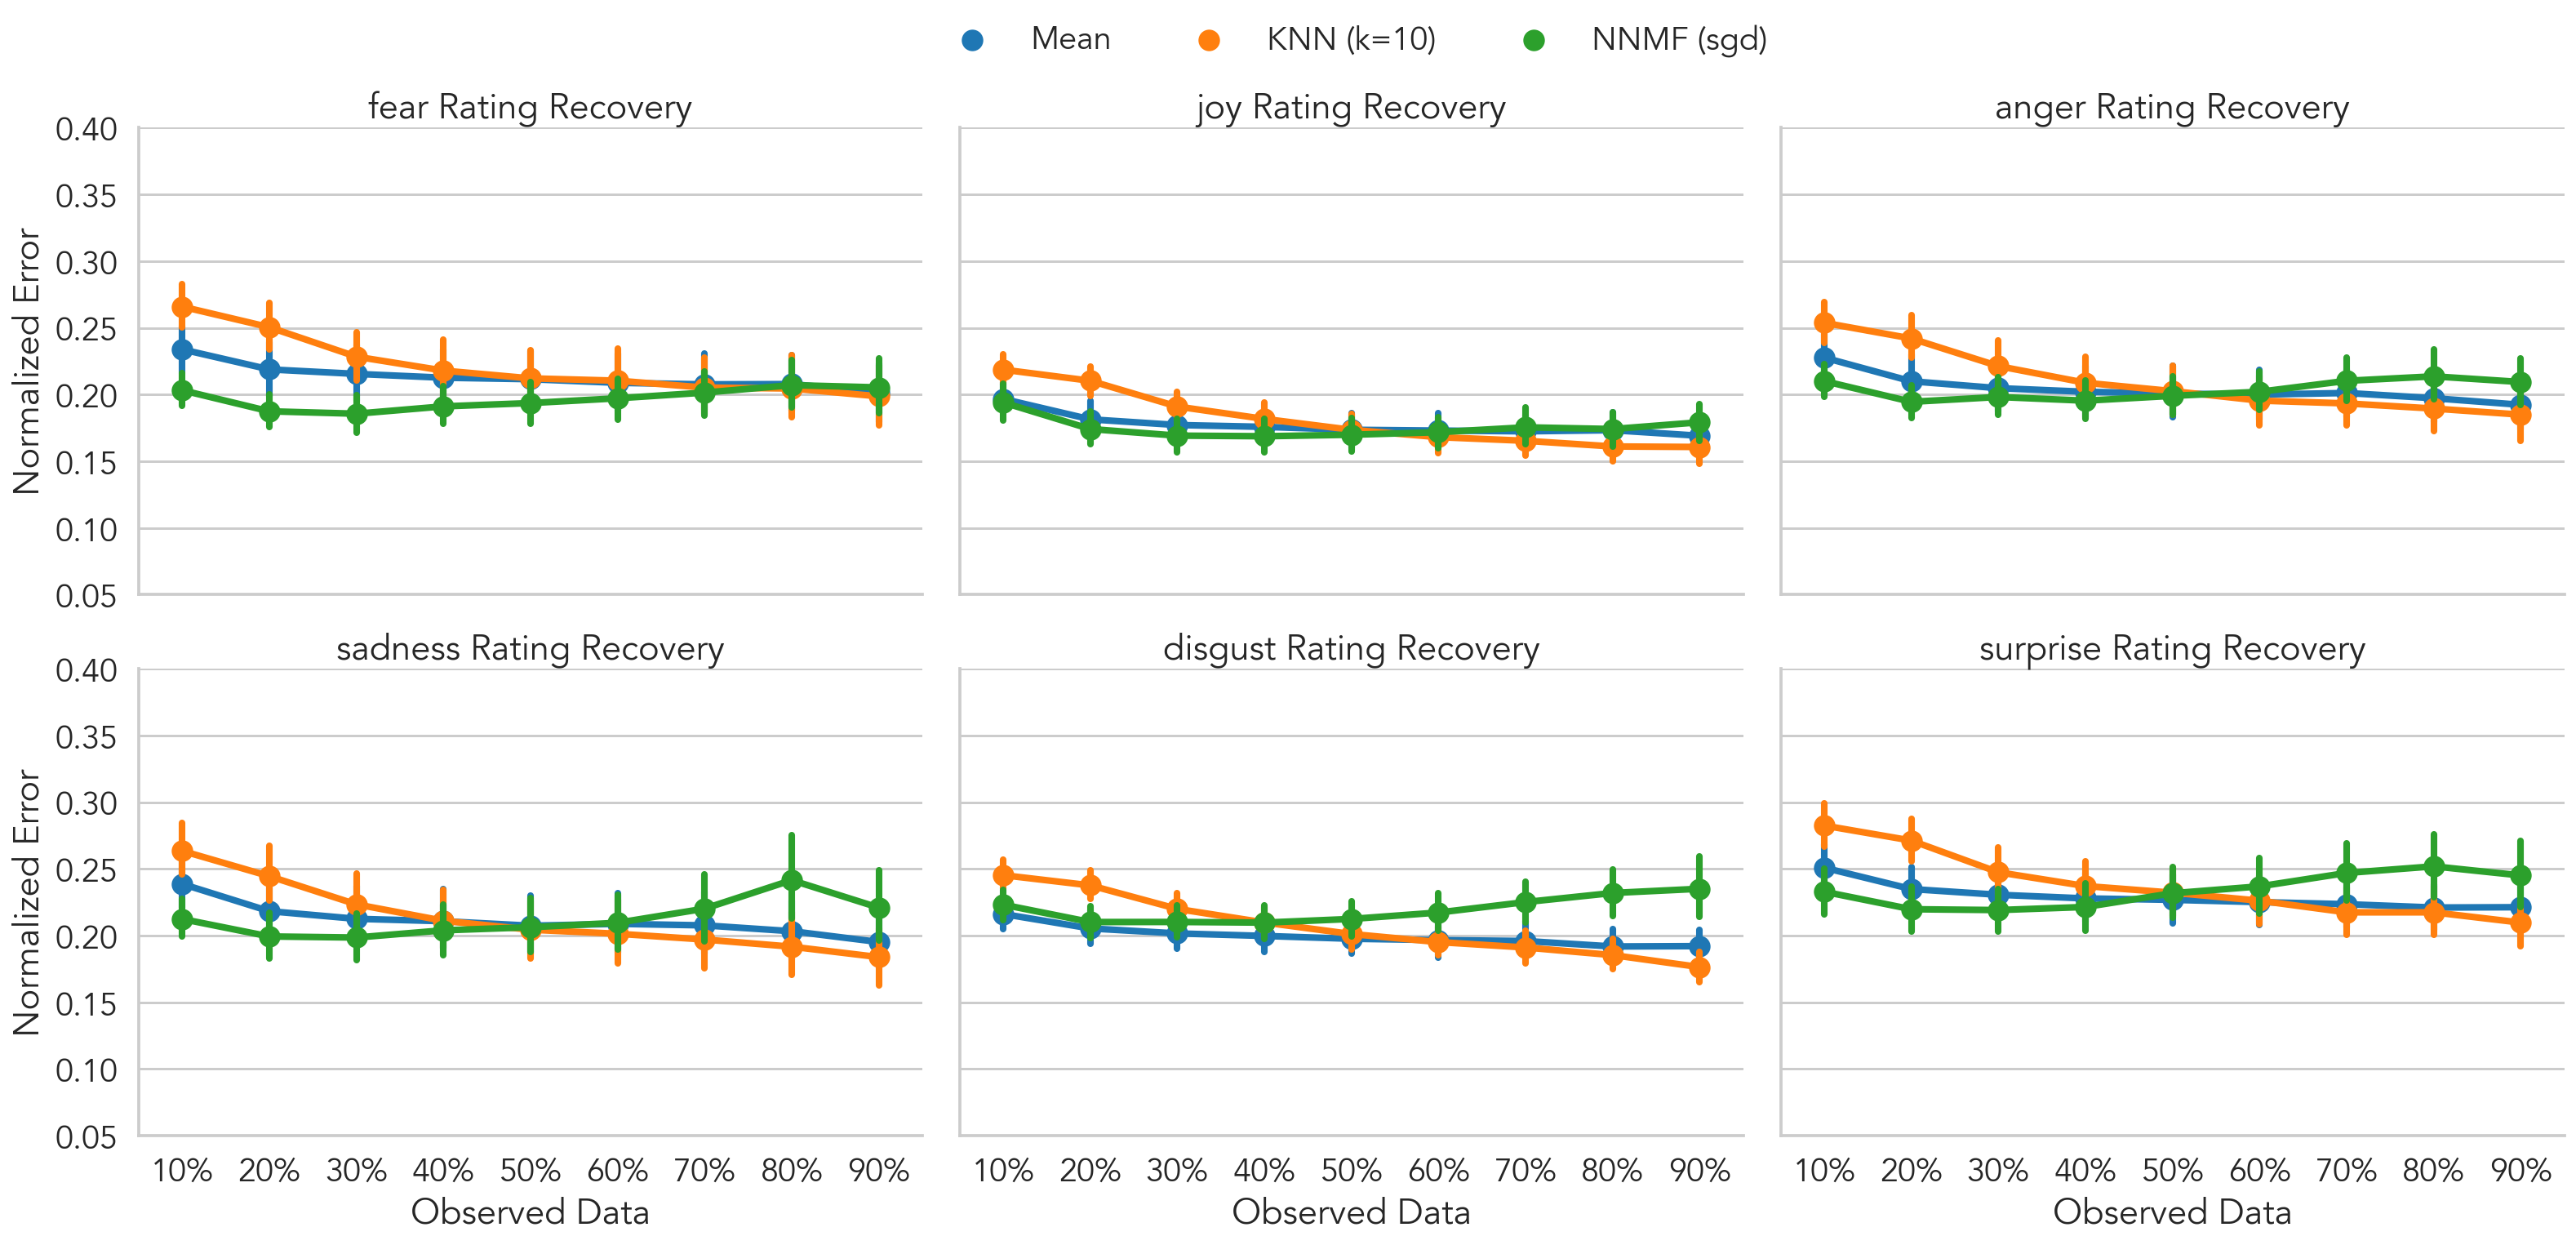

In [95]:
g = sns.catplot(
    hue="algorithm",
    col="dimension",
    col_wrap=3,
    x="Samples_Perc",
    y="score",
    order=["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"],
    hue_order=["Mean", "KNN (k=10)", "NNMF (sgd)"],
    data=iaps_plot.query("dilation == 0 and n_factors == 'all'").reset_index(drop=True),
    aspect=1.5,
    height=5,
    kind="point",
    legend=False,
    units="user",
)
g.set_titles(col_template="{col_name} Rating Recovery")
g.set_ylabels("Normalized Error")
g.set_xlabels("Observed Data")
g.set(ylim=(0.05, 0.40))
g.add_legend(loc="upper center", bbox_to_anchor=(0.4, 1.05), ncol=3)
plt.savefig(fig_dir / "iaps" / "by_emotion.pdf", bbox_inches="tight")
plt.savefig(fig_dir / "iaps" / "by_emotion.jpg", bbox_inches="tight")

## Regression comparisons

In [25]:
iaps_plot_filtered = iaps_plot.query(
    "algorithm != 'NNMF (mult)' and dilation == 0 and n_factors == 'all'"
).reset_index(drop=True)
model = Lmer("score ~ algorithm*Samples_Perc + (1|user)", data=iaps_plot_filtered)
model.fit(
    factors={
        "algorithm": ["Mean", "KNN (k=10)", "NNMF (sgd)"],
        "Samples_Perc": ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"],
    },
    summary=False,
)
# No p-val correction here because we'll do it manually below
marginals, contrasts = model.post_hoc(
    marginal_vars="algorithm", grouping_vars="Samples_Perc", p_adjust="none"
)

P-values adjusted by none method for 3 comparisons


In [27]:
# Only make orthogonal comparisons against Mean and adjust p-values using bonferroni correction
iaps_con_adjusted = (
    contrasts.query("Contrast != 'KNN (k=10) - NNMF (sgd)'")
    .assign(
        P_val_adj=lambda df: df["P-val"].apply(lambda x: x * 9),
        Sig=lambda df: df["P_val_adj"].apply(_sig_stars),
    )
    .drop(columns=["P-val"])
)
iaps_con_adjusted

Contrast Samples_Perc  Estimate  2.5_ci  97.5_ci     SE   DF  \
0   Mean - KNN (k=10)          10%    -0.028  -0.032   -0.023  0.002  inf   
1   Mean - NNMF (sgd)          10%     0.015   0.010    0.019  0.002  inf   
3   Mean - KNN (k=10)          20%    -0.031  -0.036   -0.027  0.002  inf   
4   Mean - NNMF (sgd)          20%     0.014   0.009    0.019  0.002  inf   
6   Mean - KNN (k=10)          30%    -0.015  -0.020   -0.010  0.002  inf   
7   Mean - NNMF (sgd)          30%     0.010   0.006    0.015  0.002  inf   
9   Mean - KNN (k=10)          40%    -0.006  -0.011   -0.002  0.002  inf   
10  Mean - NNMF (sgd)          40%     0.006   0.002    0.011  0.002  inf   
12  Mean - KNN (k=10)          50%    -0.001  -0.006    0.003  0.002  inf   
13  Mean - NNMF (sgd)          50%     0.001  -0.004    0.006  0.002  inf   
15  Mean - KNN (k=10)          60%     0.003  -0.002    0.007  0.002  inf   
16  Mean - NNMF (sgd)          60%    -0.004  -0.008    0.001  0.002  inf   
18  Mean - KNN (k=10)          70%     0.006   0.002    0.011  0.002  inf   
19  Mean - NNMF (sgd)          70%    -0.012  -0.017   -0.007  0.002  inf   
21  Mean - KNN (k=10)          80%     0.007   0.003    0.012  0.002  inf   
22  Mean - NNMF (sgd)          80%    -0.021  -0.026   -0.016  0.002  inf   
24  Mean - KNN (k=10)          90%     0.010   0.005    0.014  0.002  inf   
25  Mean - NNMF (sgd)          90%    -0.020  -0.025   -0.016  0.002  inf   

    Z-stat  Sig  P_val_adj  
0  -11.417  ***      0.000  
1    6.088  ***      0.000  
3  -12.934  ***      0.000  
4    5.763  ***      0.000  
6   -6.160  ***      0.000  
7    4.248  ***      0.000  
9   -2.602    .      0.081  
10   2.670    .      0.072  
12  -0.578           5.067  
13   0.342           6.597  
15   1.079           2.520  
16  -1.535           1.125  
18   2.678    .      0.063  
19  -4.879  ***      0.000  
21   3.092    *      0.018  
22  -8.619  ***      0.000  
24   3.938  ***      0.000  
25  -8.480  ***      0.000

## Example Emotion

In [3]:
iaps_example = pd.read_csv(data_dir / "iaps.csv")
mat = prepare_data(iaps_example, "iaps", "joy")

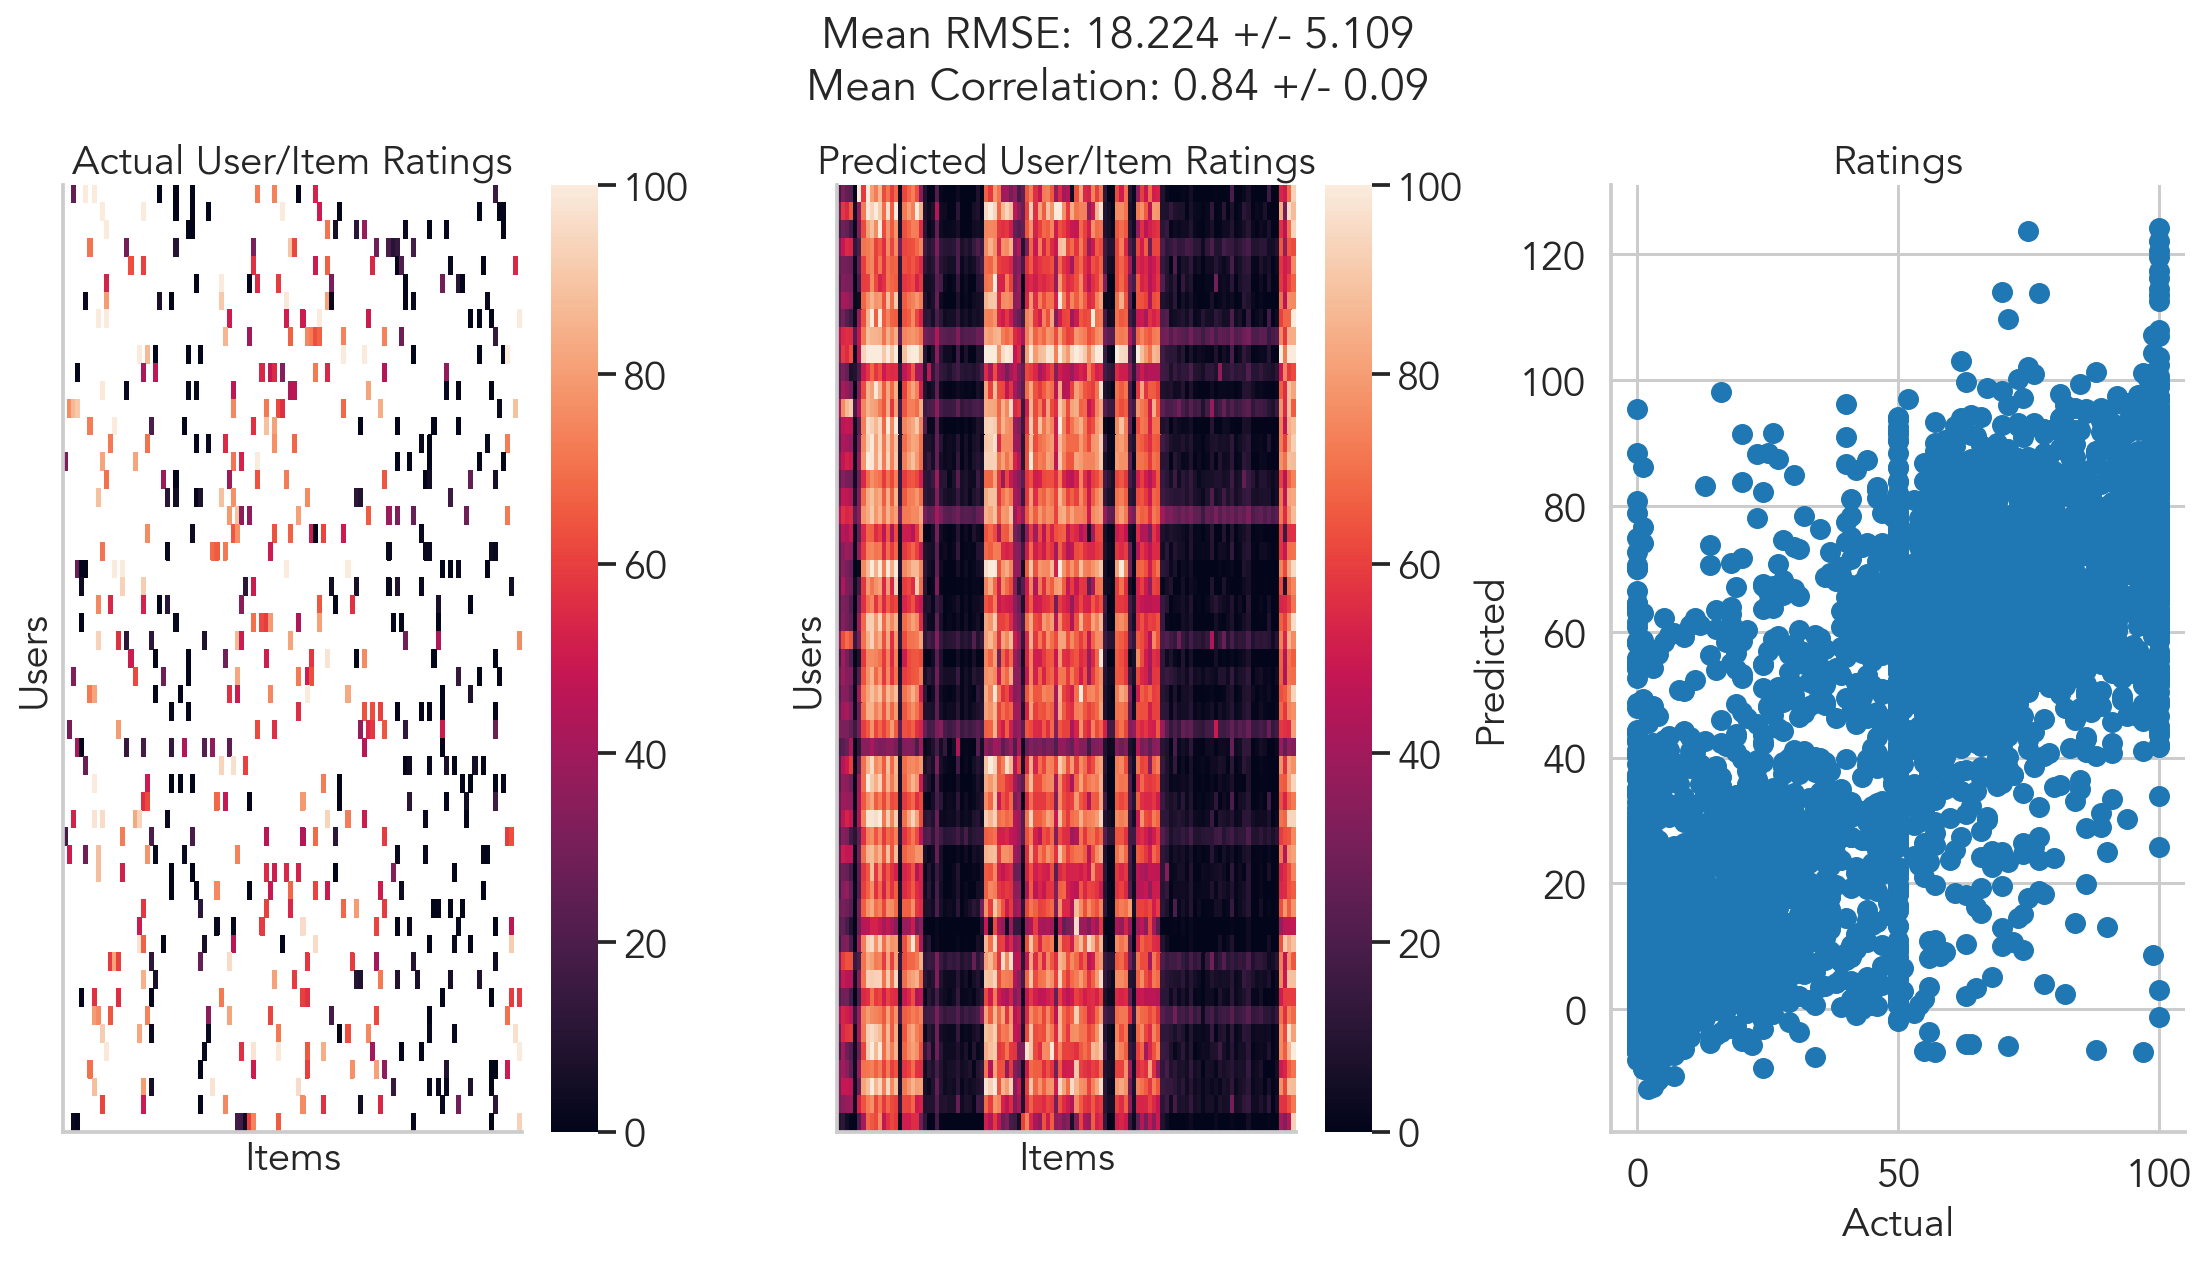

In [10]:
model = NNMF_sgd(mat, n_mask_items=0.9, random_state=0)
model.fit()
f, ax = model.plot_predictions(label_fontsize=20)
plt.subplots_adjust(wspace=0.35)
plt.savefig(fig_dir / "iaps" / "joy_example.pdf", bbox_inches="tight")
plt.savefig(fig_dir / "iaps" / "joy_example.jpg", bbox_inches="tight");

# Moth

In [49]:
moth = pd.read_csv(analysis_dir / "moth_user_model_comparison.csv")
moth_plot = prepare_df_for_plotting(moth, "moth", metric="rmse", df_type="user", normalize=100)

## Overall

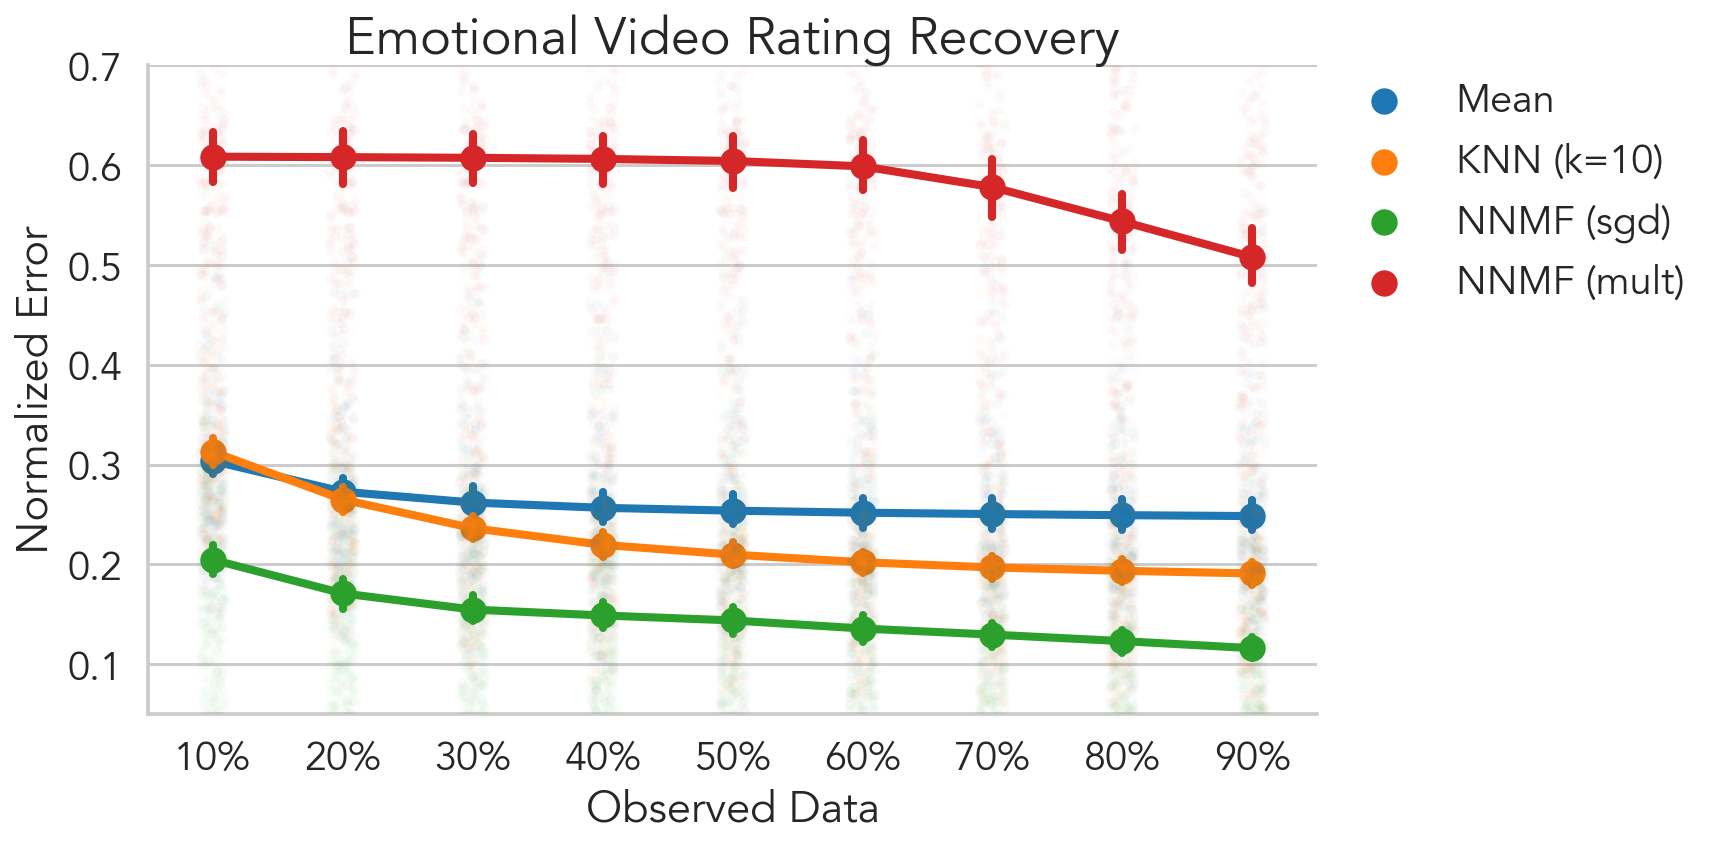

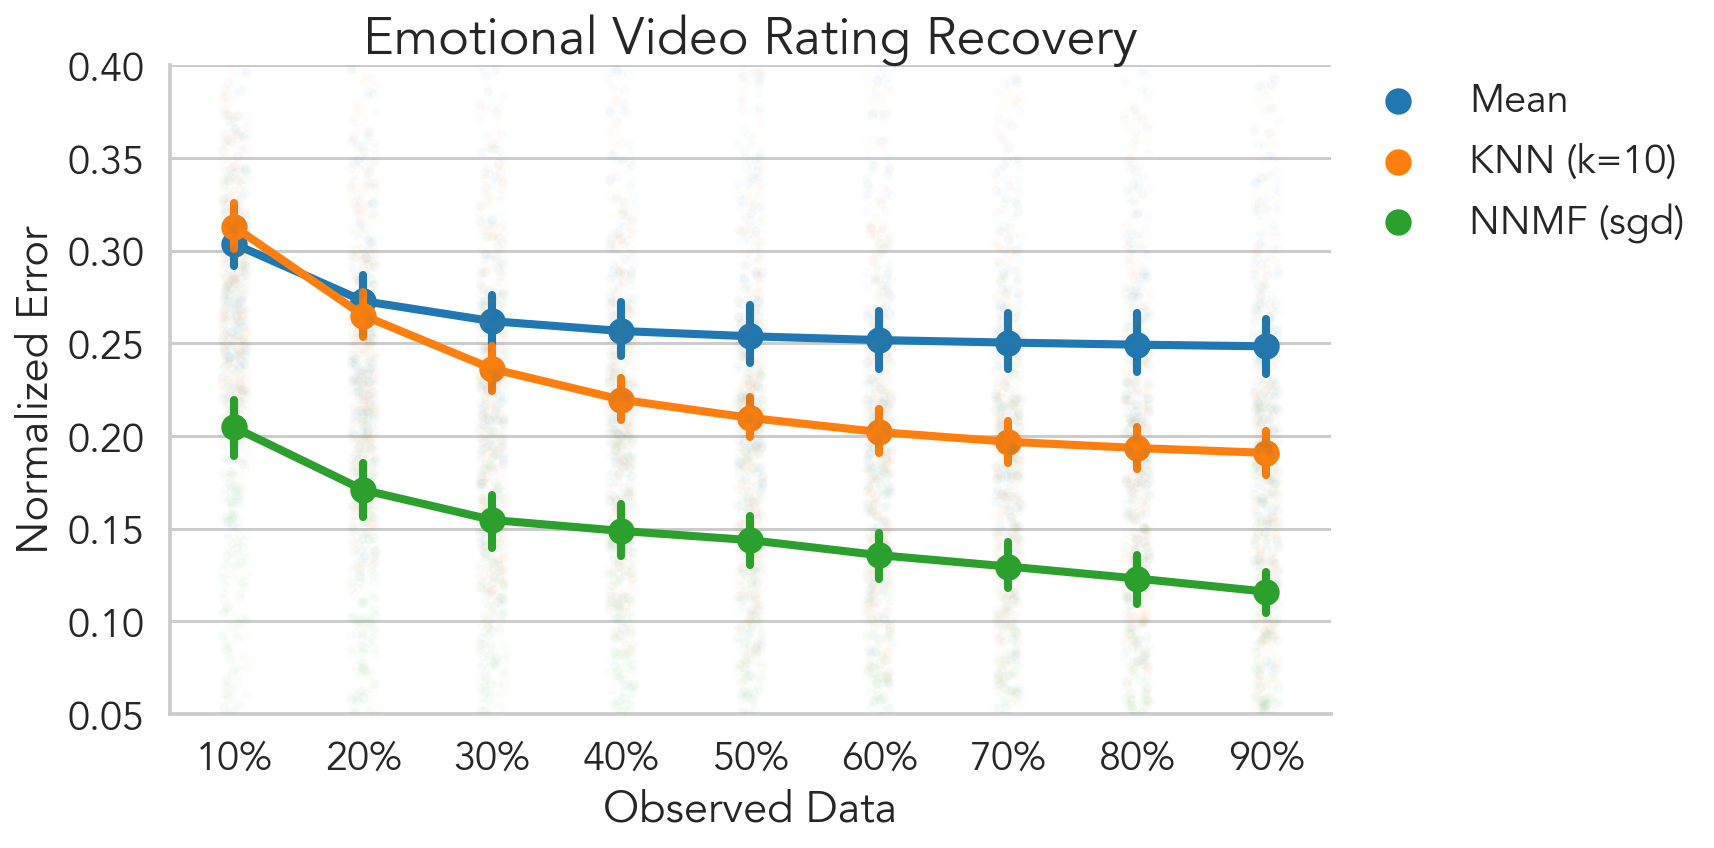

In [21]:
# With NNMF_mult
plot_overall_results(
    moth_plot,
    title="Emotional Video Rating Recovery",
    hide_nmf_m=False,
    save=fig_dir / "moth" / "overall",
    ylim=(0.05, 0.7),
)
# Without NNMF_mult
plot_overall_results(
    moth_plot,
    title="Emotional Video Rating Recovery",
    hide_nmf_m=True,
    save=fig_dir / "moth" / "overall_no_m",
    ylim=(0.05, 0.4),
);

### By Movie Plots

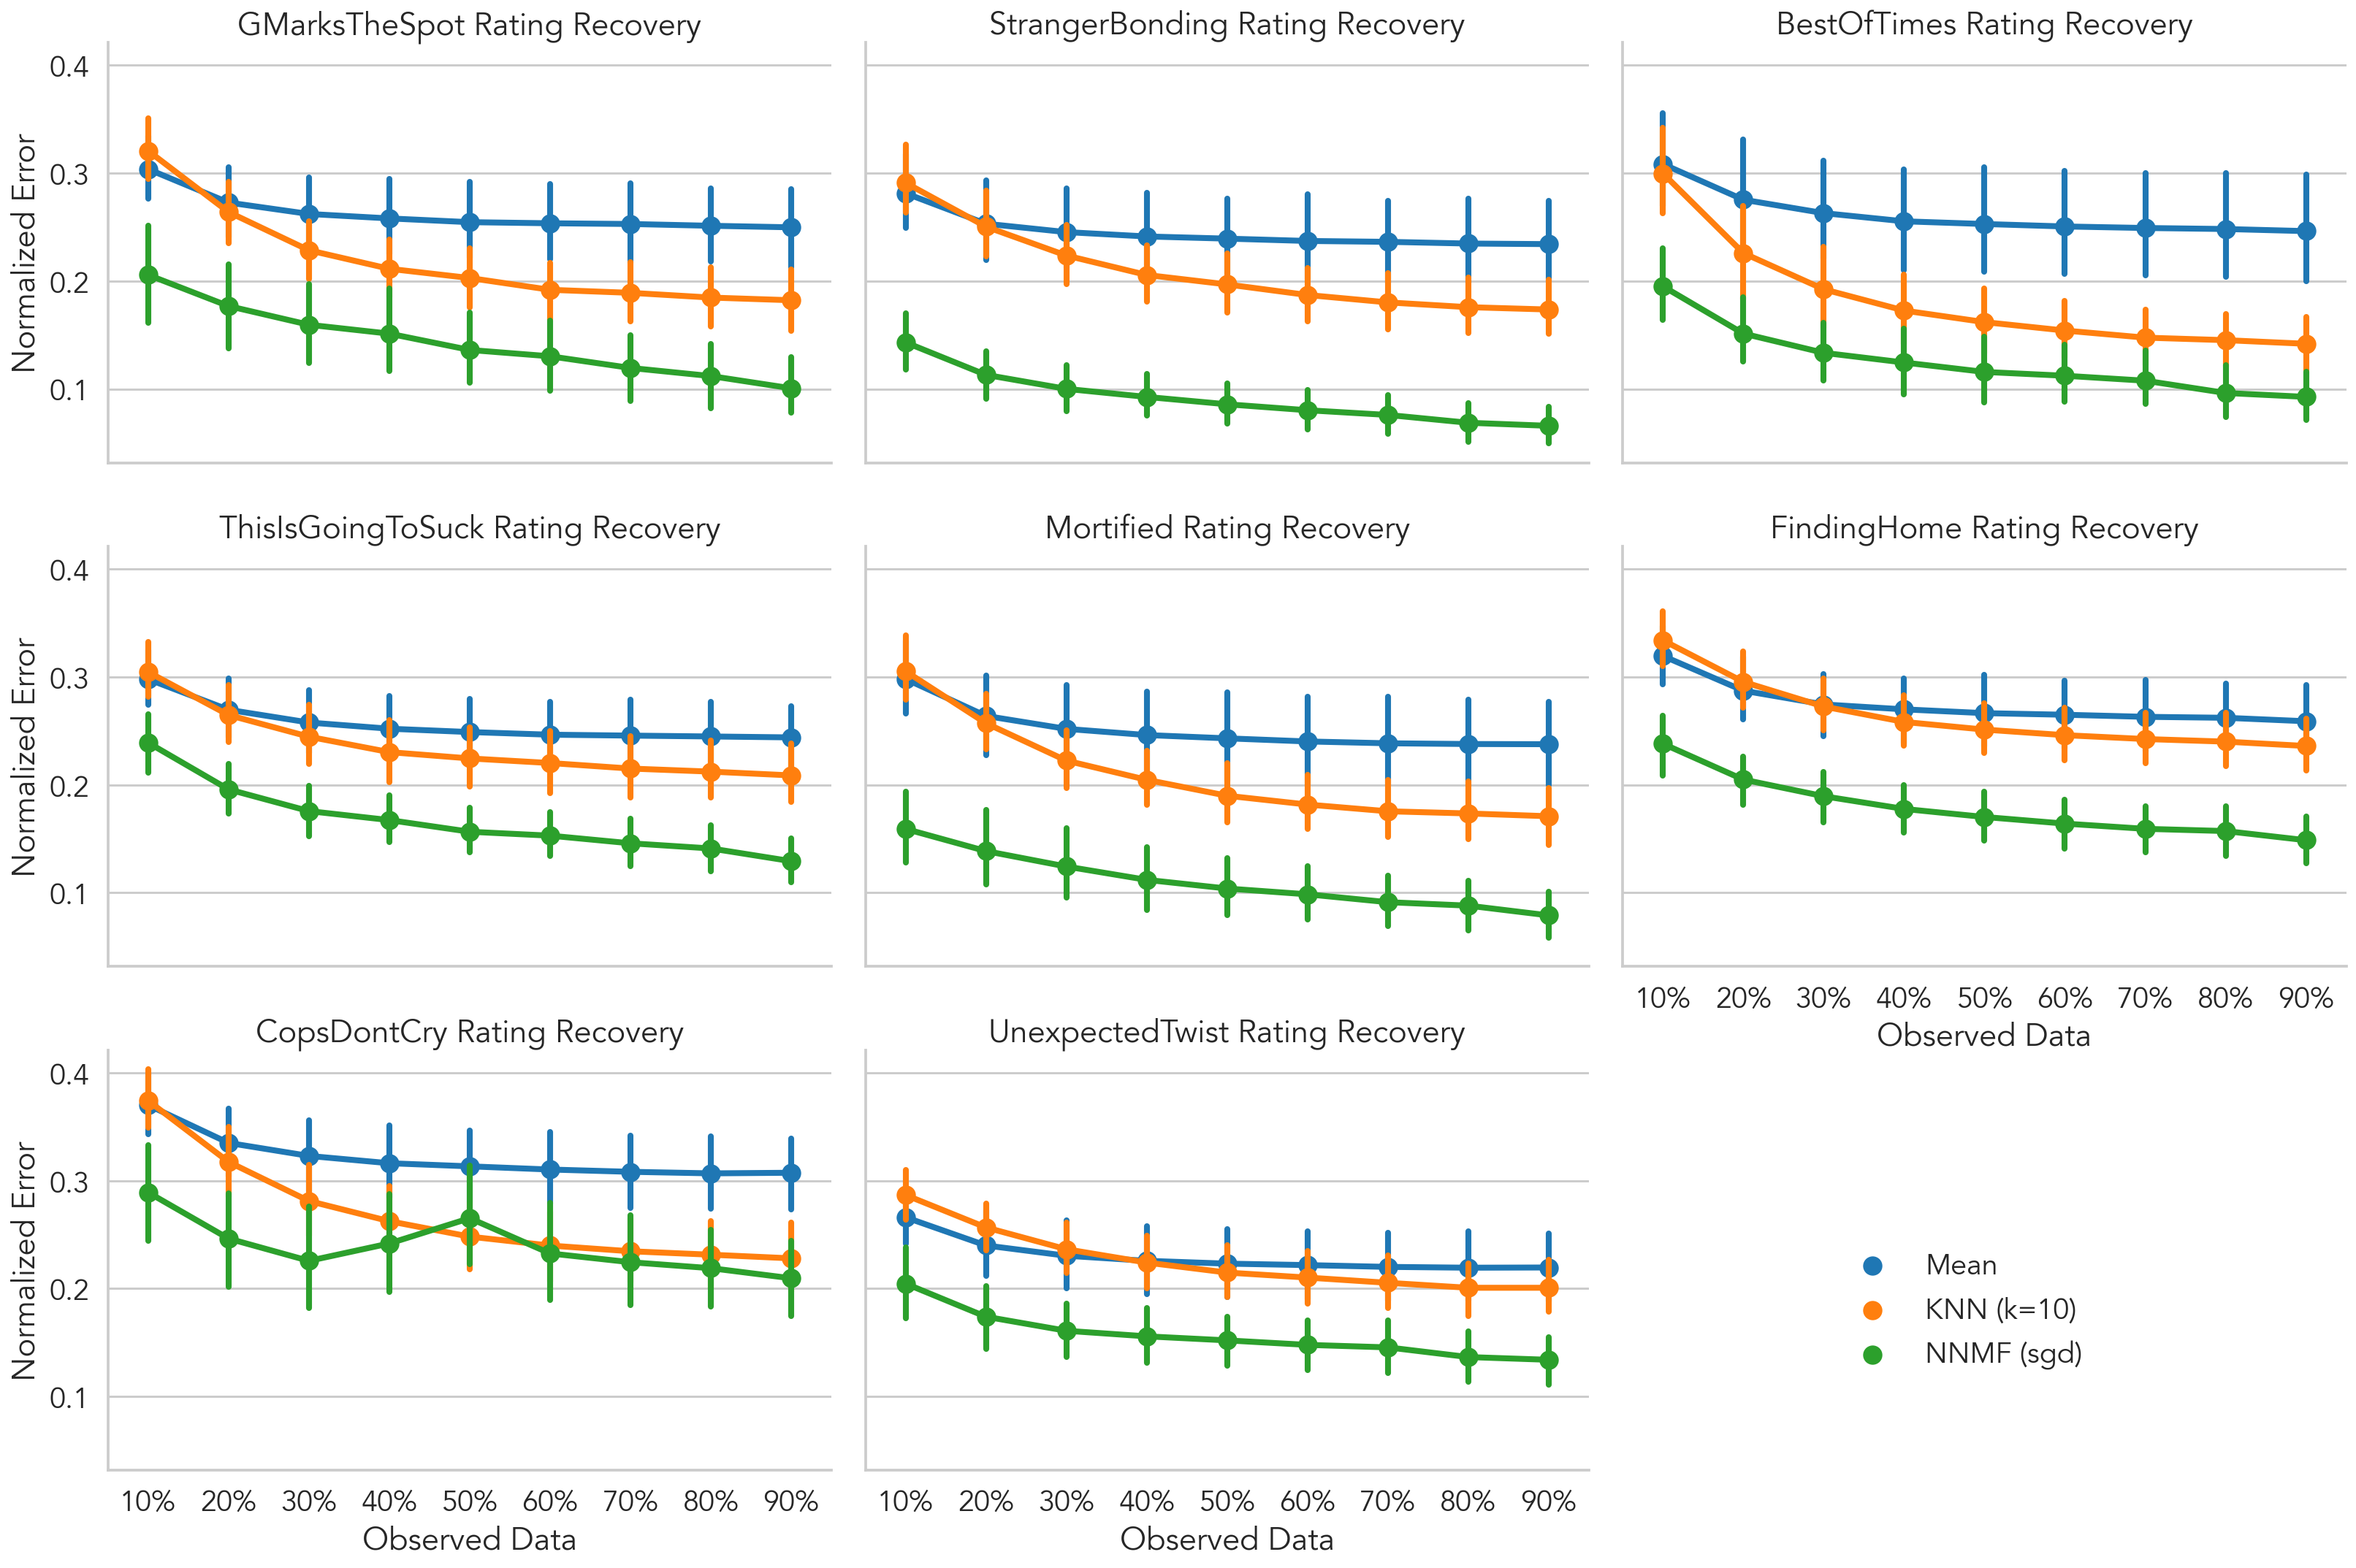

In [94]:
g = sns.catplot(
    hue="algorithm",
    col="dimension",
    col_wrap=3,
    x="Samples_Perc",
    y="score",
    order=["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"],
    col_order=[
        "GMarksTheSpot",
        "StrangerBonding",
        "BestOfTimes",
        "ThisIsGoingToSuck",
        "Mortified",
        "FindingHome",
        "CopsDontCry",
        "UnexpectedTwist",
    ],
    hue_order=["Mean", "KNN (k=10)", "NNMF (sgd)"],
    units="user",
    data=moth_plot.query("dilation == 0 and n_factors == 'all'").reset_index(drop=True),
    aspect=1.5,
    height=5,
    kind="point",
    legend=False,
)
g.set_titles(col_template="{col_name} Rating Recovery")
g.set_ylabels("Normalized Error")
g.set_xlabels("Observed Data")
g.add_legend(loc="lower right", bbox_to_anchor=(0.8, 0.1))
plt.savefig(fig_dir / "moth" / "by_movie.pdf", bbox_inches="tight")
plt.savefig(fig_dir / "moth" / "by_movie.jpg", bbox_inches="tight")

## Regression comparisons

In [31]:
moth_plot_filtered = moth_plot.query(
    "algorithm != 'NNMF (mult)' and dilation == 0 and n_factors == 'all'"
).reset_index(drop=True)
model = Lmer("score ~ algorithm*Samples_Perc + (1|user)", data=moth_plot_filtered)
model.fit(
    factors={
        "algorithm": ["Mean", "KNN (k=10)", "NNMF (sgd)"],
        "Samples_Perc": ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"],
    },
    summary=False,
)
# No p-val correction here because we'll do it manually below
marginals, contrasts = model.post_hoc(
    marginal_vars="algorithm", grouping_vars="Samples_Perc", p_adjust="none"
)

P-values adjusted by none method for 3 comparisons


In [32]:
# Only make orthogonal comparisons against Mean and adjust p-values using bonferroni correction
moth_con_adjusted = (
    contrasts.query("Contrast != 'KNN (k=10) - NNMF (sgd)'")
    .assign(
        P_val_adj=lambda df: df["P-val"].apply(lambda x: x * 9),
        Sig=lambda df: df["P_val_adj"].apply(_sig_stars),
    )
    .drop(columns=["P-val"])
)
moth_con_adjusted

Contrast Samples_Perc  Estimate  2.5_ci  97.5_ci     SE   DF  \
0   Mean - KNN (k=10)          10%    -0.009  -0.020    0.001  0.005  inf   
1   Mean - NNMF (sgd)          10%     0.099   0.089    0.109  0.005  inf   
3   Mean - KNN (k=10)          20%     0.008  -0.003    0.018  0.005  inf   
4   Mean - NNMF (sgd)          20%     0.102   0.092    0.112  0.005  inf   
6   Mean - KNN (k=10)          30%     0.026   0.015    0.036  0.005  inf   
7   Mean - NNMF (sgd)          30%     0.107   0.097    0.118  0.005  inf   
9   Mean - KNN (k=10)          40%     0.037   0.027    0.047  0.005  inf   
10  Mean - NNMF (sgd)          40%     0.108   0.097    0.118  0.005  inf   
12  Mean - KNN (k=10)          50%     0.044   0.034    0.054  0.005  inf   
13  Mean - NNMF (sgd)          50%     0.110   0.100    0.120  0.005  inf   
15  Mean - KNN (k=10)          60%     0.050   0.039    0.060  0.005  inf   
16  Mean - NNMF (sgd)          60%     0.116   0.106    0.126  0.005  inf   
18  Mean - KNN (k=10)          70%     0.053   0.043    0.064  0.005  inf   
19  Mean - NNMF (sgd)          70%     0.121   0.110    0.131  0.005  inf   
21  Mean - KNN (k=10)          80%     0.056   0.045    0.066  0.005  inf   
22  Mean - NNMF (sgd)          80%     0.126   0.116    0.137  0.005  inf   
24  Mean - KNN (k=10)          90%     0.057   0.047    0.068  0.005  inf   
25  Mean - NNMF (sgd)          90%     0.132   0.122    0.143  0.005  inf   

    Z-stat  Sig  P_val_adj  
0   -1.734           0.747  
1   18.732  ***      0.000  
3    1.480           1.251  
4   19.280  ***      0.000  
6    4.865  ***      0.000  
7   20.291  ***      0.000  
9    7.012  ***      0.000  
10  20.405  ***      0.000  
12   8.335  ***      0.000  
13  20.809  ***      0.000  
15   9.389  ***      0.000  
16  21.956  ***      0.000  
18  10.121  ***      0.000  
19  22.858  ***      0.000  
21  10.548  ***      0.000  
22  23.873  ***      0.000  
24  10.874  ***      0.000  
25  25.043  ***      0.000

## By Dilation

In [33]:
train_sizes = ["10%", "50%", "90%"]
moth_dil_plot = (
    moth_plot.query(
        "n_factors == 'all' and Samples_Perc in @train_sizes and algorithm != 'NNMF (mult)'"
    )
    .reset_index(drop=True)
    .assign(
        Dilation=lambda df: df.dilation.map({0: "None", 5: "5s", 20: "20s", 60: "60s"}),
        dil_con=lambda df: df.Dilation.map({"None": -1, "5s": -0.5, "20s": 0.5, "60s": 1}),
        train_con=lambda df: df.Samples_Perc.map({"10%": -0.5, "50%": 0, "90%": 0.5}),
    )
)

### Dilation regression comparisons

In [41]:
model = Lmer("score ~ algorithm*Samples_Perc*Dilation + (1 | user)", data=moth_dil_plot)
model.fit(
    factors={
        "algorithm": ["Mean", "KNN (k=10)", "NNMF (sgd)"],
        "Samples_Perc": ["10%", "50%", "90%"],
        "Dilation": ["None", "5s", "20s", "60s"],
    },
    ordered=True,
    summary=False,
)
marginals, comparisons = model.post_hoc(
    marginal_vars="Dilation", grouping_vars=["Samples_Perc", "algorithm"], p_adjust="none"
)

P-values adjusted by none method for 6 comparisons


In [43]:
marginals

Dilation Samples_Perc   algorithm  Estimate  2.5_ci  97.5_ci     SE   DF
0      None          10%        Mean     0.302   0.289    0.314  0.006  inf
1        5s          10%        Mean     0.248   0.236    0.261  0.006  inf
2       20s          10%        Mean     0.243   0.230    0.255  0.006  inf
3       60s          10%        Mean     0.248   0.236    0.261  0.006  inf
4      None          50%        Mean     0.252   0.239    0.264  0.006  inf
5        5s          50%        Mean     0.239   0.227    0.252  0.006  inf
6       20s          50%        Mean     0.241   0.229    0.254  0.006  inf
7       60s          50%        Mean     0.248   0.235    0.260  0.006  inf
8      None          90%        Mean     0.246   0.234    0.259  0.006  inf
9        5s          90%        Mean     0.238   0.226    0.251  0.006  inf
10      20s          90%        Mean     0.241   0.228    0.254  0.006  inf
11      60s          90%        Mean     0.248   0.235    0.260  0.006  inf
12     None          10%  KNN (k=10)     0.311   0.298    0.323  0.006  inf
13       5s          10%  KNN (k=10)     0.222   0.209    0.235  0.006  inf
14      20s          10%  KNN (k=10)     0.202   0.190    0.215  0.006  inf
15      60s          10%  KNN (k=10)     0.210   0.197    0.222  0.006  inf
16     None          50%  KNN (k=10)     0.208   0.195    0.220  0.006  inf
17       5s          50%  KNN (k=10)     0.189   0.176    0.201  0.006  inf
18      20s          50%  KNN (k=10)     0.190   0.177    0.202  0.006  inf
19      60s          50%  KNN (k=10)     0.201   0.189    0.214  0.006  inf
20     None          90%  KNN (k=10)     0.189   0.176    0.201  0.006  inf
21       5s          90%  KNN (k=10)     0.185   0.172    0.198  0.006  inf
22      20s          90%  KNN (k=10)     0.188   0.176    0.201  0.006  inf
23      60s          90%  KNN (k=10)     0.198   0.186    0.211  0.006  inf
24     None          10%  NNMF (sgd)     0.203   0.190    0.215  0.006  inf
25       5s          10%  NNMF (sgd)     0.127   0.115    0.140  0.006  inf
26      20s          10%  NNMF (sgd)     0.118   0.105    0.130  0.006  inf
27      60s          10%  NNMF (sgd)     0.148   0.136    0.161  0.006  inf
28     None          50%  NNMF (sgd)     0.142   0.129    0.154  0.006  inf
29       5s          50%  NNMF (sgd)     0.071   0.058    0.083  0.006  inf
30      20s          50%  NNMF (sgd)     0.099   0.086    0.111  0.006  inf
31      60s          50%  NNMF (sgd)     0.140   0.127    0.152  0.006  inf
32     None          90%  NNMF (sgd)     0.114   0.101    0.127  0.006  inf
33       5s          90%  NNMF (sgd)     0.061   0.049    0.074  0.006  inf
34      20s          90%  NNMF (sgd)     0.096   0.084    0.109  0.006  inf
35      60s          90%  NNMF (sgd)     0.136   0.124    0.149  0.006  inf

In [36]:
# Only make orthogonal comparisons against no-dilation and adjust p-values using bonferroni correction
moth_dil_con_adjusted = (
    comparisons[comparisons["Contrast"].str.contains("None")]
    .assign(
        P_val_adj=lambda df: df["P-val"].apply(lambda x: x * 9),
        Sig=lambda df: df["P_val_adj"].apply(_sig_stars),
    )
    .drop(columns=["P-val"])
)
moth_dil_con_adjusted

Contrast Samples_Perc   algorithm  Estimate  2.5_ci  97.5_ci     SE  \
0    None - 5s          10%        Mean     0.053   0.043    0.064  0.005   
1   None - 20s          10%        Mean     0.059   0.048    0.069  0.005   
2   None - 60s          10%        Mean     0.053   0.043    0.064  0.005   
6    None - 5s          50%        Mean     0.013   0.002    0.023  0.005   
7   None - 20s          50%        Mean     0.011   0.000    0.021  0.005   
8   None - 60s          50%        Mean     0.004  -0.006    0.014  0.005   
12   None - 5s          90%        Mean     0.008  -0.002    0.019  0.005   
13  None - 20s          90%        Mean     0.005  -0.005    0.016  0.005   
14  None - 60s          90%        Mean    -0.001  -0.012    0.009  0.005   
18   None - 5s          10%  KNN (k=10)     0.089   0.078    0.099  0.005   
19  None - 20s          10%  KNN (k=10)     0.108   0.098    0.119  0.005   
20  None - 60s          10%  KNN (k=10)     0.101   0.091    0.111  0.005   
24   None - 5s          50%  KNN (k=10)     0.019   0.009    0.030  0.005   
25  None - 20s          50%  KNN (k=10)     0.018   0.007    0.028  0.005   
26  None - 60s          50%  KNN (k=10)     0.007  -0.004    0.017  0.005   
30   None - 5s          90%  KNN (k=10)     0.004  -0.007    0.014  0.005   
31  None - 20s          90%  KNN (k=10)     0.001  -0.010    0.011  0.005   
32  None - 60s          90%  KNN (k=10)    -0.009  -0.020    0.001  0.005   
36   None - 5s          10%  NNMF (sgd)     0.075   0.065    0.085  0.005   
37  None - 20s          10%  NNMF (sgd)     0.085   0.074    0.095  0.005   
38  None - 60s          10%  NNMF (sgd)     0.054   0.044    0.065  0.005   
42   None - 5s          50%  NNMF (sgd)     0.071   0.061    0.081  0.005   
43  None - 20s          50%  NNMF (sgd)     0.043   0.033    0.054  0.005   
44  None - 60s          50%  NNMF (sgd)     0.002  -0.008    0.012  0.005   
48   None - 5s          90%  NNMF (sgd)     0.053   0.042    0.063  0.005   
49  None - 20s          90%  NNMF (sgd)     0.018   0.007    0.028  0.005   
50  None - 60s          90%  NNMF (sgd)    -0.022  -0.033   -0.012  0.005   

     DF  Z-stat  Sig  P_val_adj  
0   inf  10.008  ***      0.000  
1   inf  11.082  ***      0.000  
2   inf  10.036  ***      0.000  
6   inf   2.358           0.162  
7   inf   1.979           0.432  
8   inf   0.755           4.050  
12  inf   1.542           1.107  
13  inf   0.989           2.907  
14  inf  -0.279           7.020  
18  inf  16.702  ***      0.000  
19  inf  20.407  ***      0.000  
20  inf  18.990  ***      0.000  
24  inf   3.592  ***      0.000  
25  inf   3.351   **      0.009  
26  inf   1.234           1.953  
30  inf   0.722           4.230  
31  inf   0.133           8.046  
32  inf  -1.755           0.711  
36  inf  14.124  ***      0.000  
37  inf  15.939  ***      0.000  
38  inf  10.177  ***      0.000  
42  inf  13.356  ***      0.000  
43  inf   8.123  ***      0.000  
44  inf   0.366           6.426  
48  inf   9.937  ***      0.000  
49  inf   3.309   **      0.009  
50  inf  -4.176  ***      0.000

### Dilation plot

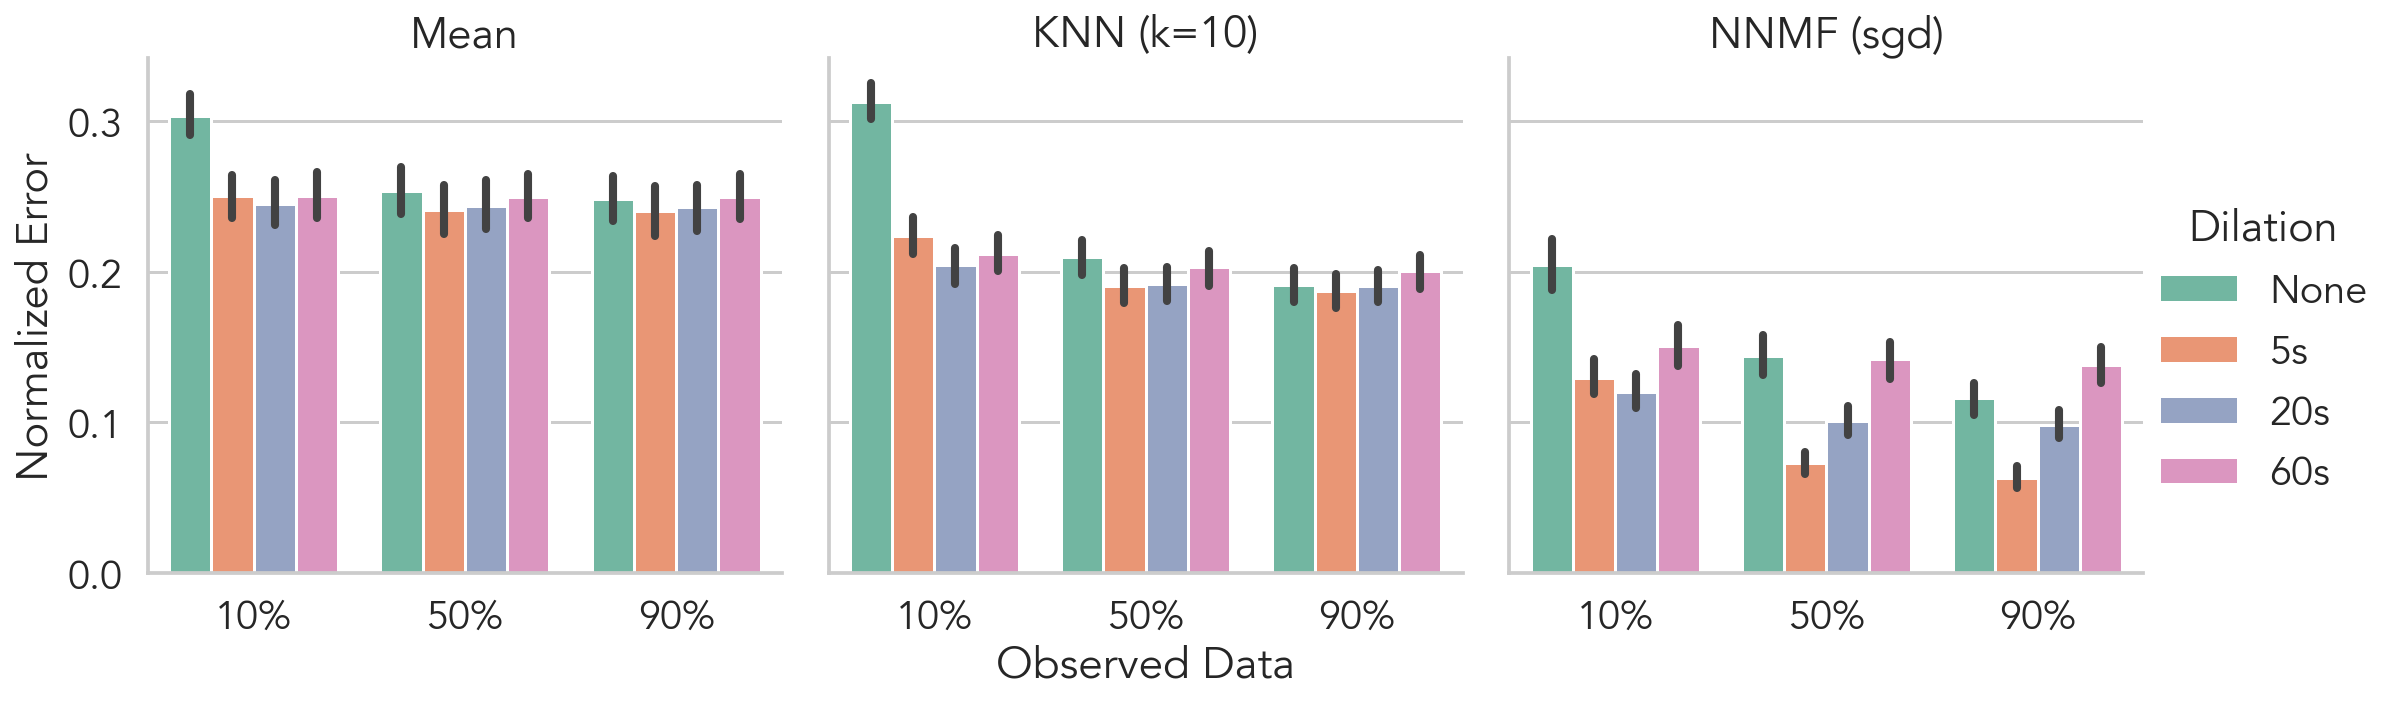

In [129]:
moth_dil_plots = moth_dil_plot.rename(
    columns={
        "score": "Normalized Error",
        "Samples_Perc": "Observed Data",
    }
)
g = sns.catplot(
    x="Observed Data",
    y="Normalized Error",
    hue="Dilation",
    col="algorithm",
    units="user",
    n_boot=500,
    kind="bar",
    data=moth_dil_plot,
    col_order=["Mean", "KNN (k=10)", "NNMF (sgd)"],
    hue_order=["None", "5s", "20s", "60s"],
    palette=sns.color_palette("Set2"),
)
g.set_titles(col_template="{col_name}")
g.set_xlabels("")
g.fig.text(0.5, -0.2, "Observed Data", fontsize=22, ha="center", transform=g.axes[0][1].transAxes)
plt.savefig(fig_dir / "moth" / "dilation.pdf", bbox_inches="tight")
plt.savefig(fig_dir / "moth" / "dilation.jpg", bbox_inches="tight");

## Example time-series

In [4]:
moth_example = pd.read_csv(data_dir / "moth.csv")
moth_example = prepare_data(moth_example, "moth", "GMarksTheSpot")

In [5]:
model_10_0 = NNMF_sgd(moth_example, n_mask_items=0.9, random_state=0)
model_10_0.fit()
model_10_5 = NNMF_sgd(moth_example, n_mask_items=0.9, random_state=0)
model_10_5.fit(dilate_by_nsamples=5)

model_90_0 = NNMF_sgd(moth_example, n_mask_items=0.1, random_state=0)
model_90_0.fit()
model_90_5 = NNMF_sgd(moth_example, n_mask_items=0.1, random_state=0)
model_90_5.fit(dilate_by_nsamples=5)

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 [Text(-100.0, 0, ''),
  Text(0.0, 0, ''),
  Text(100.0, 0, ''),
  Text(200.0, 0, ''),
  Text(300.0, 0, ''),
  Text(400.0, 0, '')]]

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 [Text(-100.0, 0, ''),
  Text(0.0, 0, ''),
  Text(100.0, 0, ''),
  Text(200.0, 0, ''),
  Text(300.0, 0, ''),
  Text(400.0, 0, '')],
 [Text(0, -50.0, ''),
  Text(0, 0.0, ''),
  Text(0, 50.0, ''),
  Text(0, 100.0, ''),
  Text(0, 150.0, '')]]

[Text(0, 0.5, ''), Text(0.5, 0, '')]

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 [Text(0, -50.0, ''),
  Text(0, 0.0, ''),
  Text(0, 50.0, ''),
  Text(0, 100.0, ''),
  Text(0, 150.0, '')]]

Text(0.5, 0.0, 'Time')

Text(0, 0.47, 'Valence')

Text(0.012, 0.1, '$\\longleftarrow$')

Text(0.01, 0.16, 'Negative')

Text(0.012, 0.9, '$\\longrightarrow$')

Text(0.01, 0.8, 'Positive')

Text(0.23, 1.0, 'No Dilation')

Text(0.73, 1.0, '5s Dilation')

Text(-0.04, 0.57, '10% Observed Data')

Text(-0.04, 0.11, '90% Observed Data')

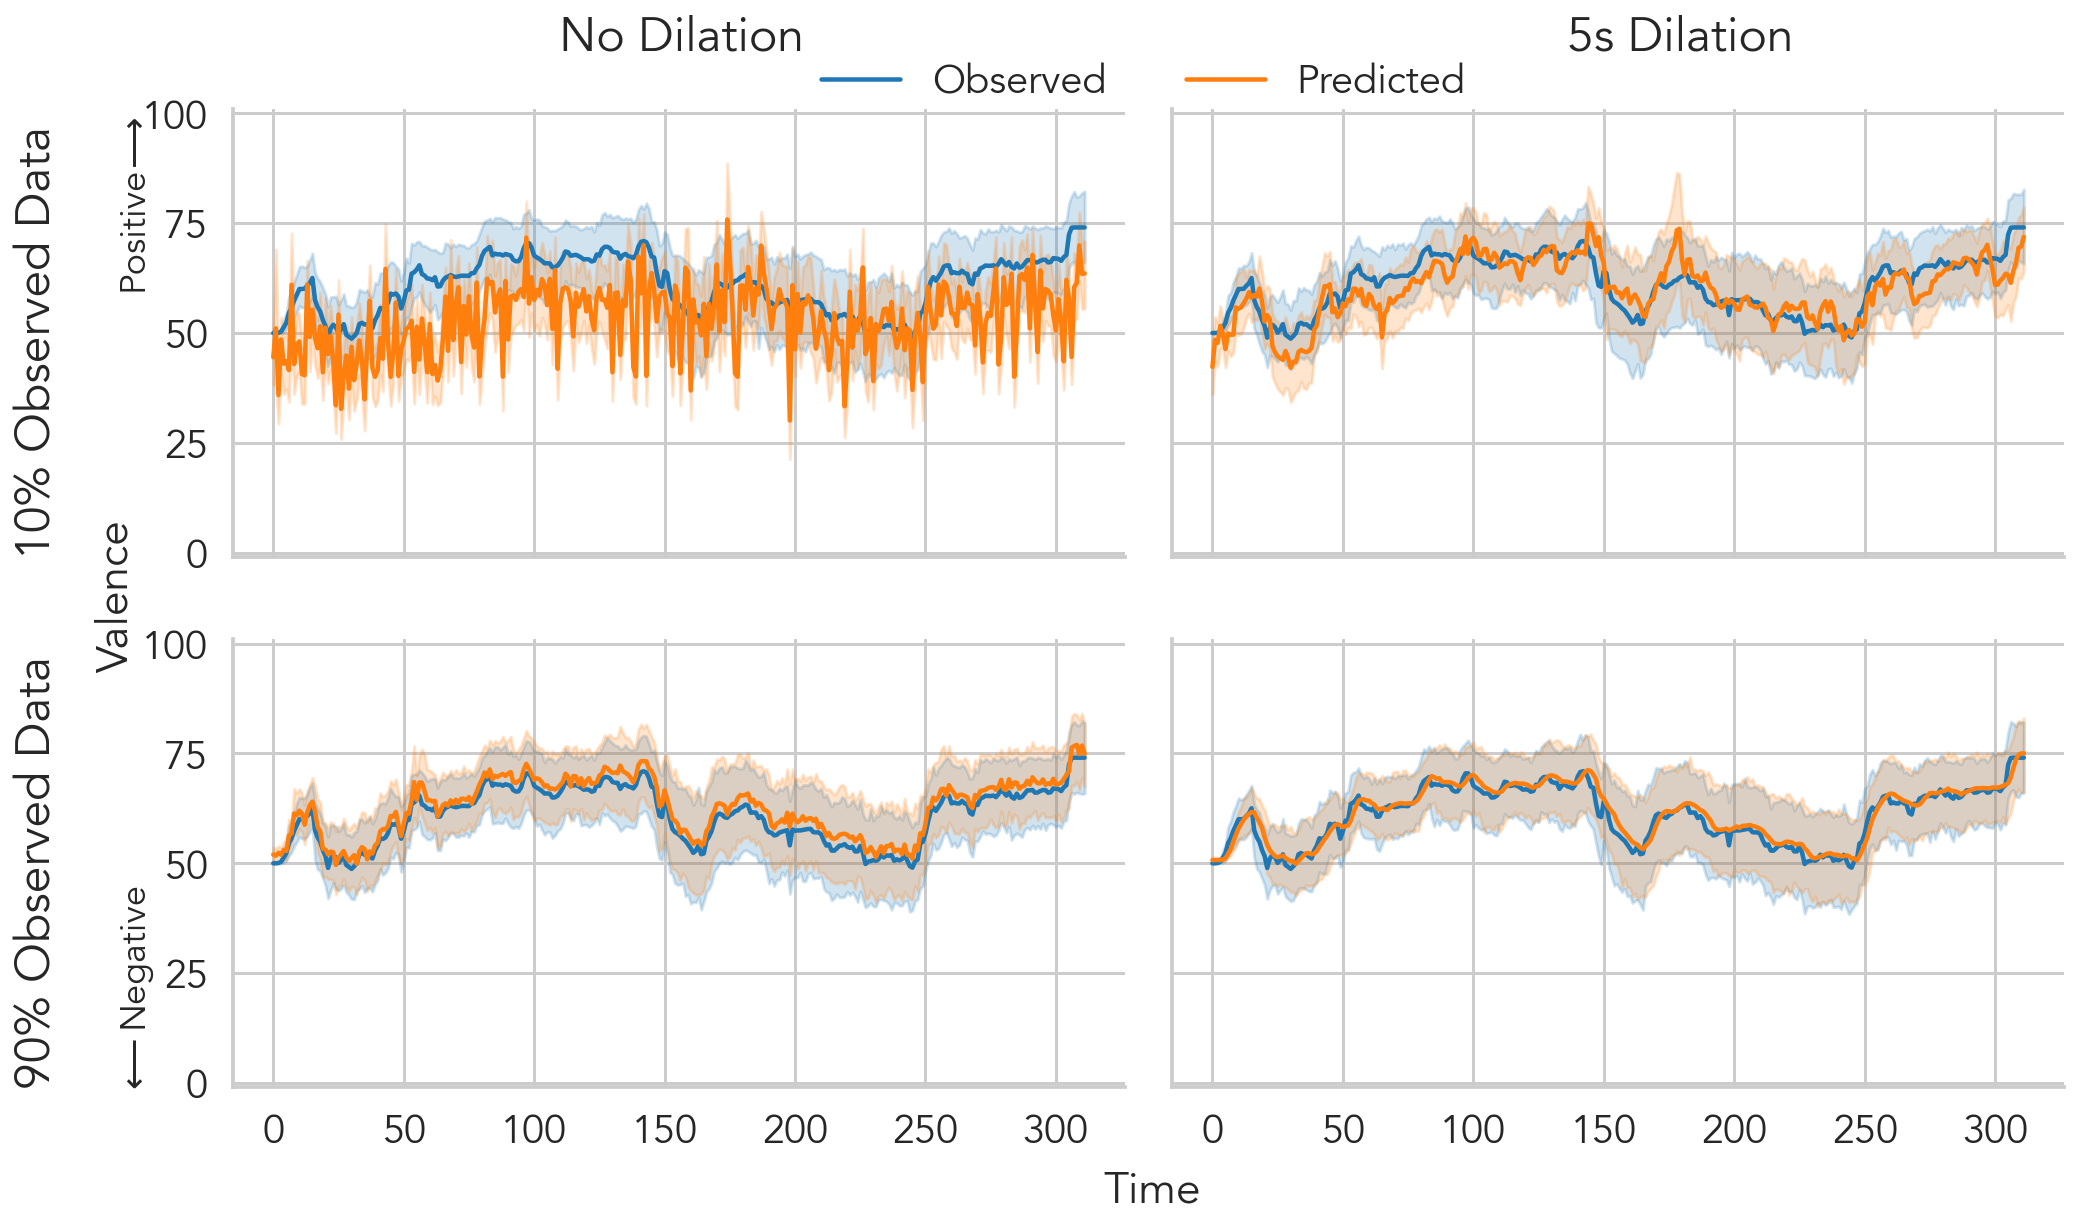

In [40]:
f, axs = plt.subplots(2, 2, figsize=(14, 8))
ax = plot_timeseries_predictions(model_10_0, ax=axs.flat[0], remove_legend=True)
ax.set(ylabel="", xlabel="", xticklabels=[])
ax = plot_timeseries_predictions(model_10_5, ax=axs.flat[1], remove_legend=True)
ax.set(ylabel="", xlabel="", xticklabels=[], yticklabels=[])
ax = plot_timeseries_predictions(model_90_0, ax=axs.flat[2], remove_legend=True)
ax.set(ylabel="", xlabel="")
ax = plot_timeseries_predictions(model_90_5, ax=axs.flat[3])
ax.set(ylabel="", xlabel="", yticklabels=[])
handles, labels = plt.gca().get_legend_handles_labels()
ax.get_legend().remove()

f.text(0.5, 0.0, "Time", fontsize=22)
f.text(0, 0.47, "Valence", fontsize=22, rotation=90)
f.text(0.012, 0.10, r"$\longleftarrow$", fontsize=18, rotation=90)
f.text(0.01, 0.16, "Negative", fontsize=18, rotation=90)
f.text(0.012, 0.9, r"$\longrightarrow$", fontsize=18, rotation=90)
f.text(0.01, 0.8, "Positive", fontsize=18, rotation=90)
f.text(0.23, 1.0, "No Dilation", fontsize=24)
f.text(0.73, 1.0, "5s Dilation", fontsize=24)
f.text(-0.04, 0.57, "10% Observed Data", fontsize=24, rotation=90)
f.text(-0.04, 0.11, "90% Observed Data", fontsize=24, rotation=90)
f.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.52, 1.02), frameon=False)

plt.tight_layout()
plt.savefig(fig_dir / "moth" / "example_timeseries.jpg", bbox_inches="tight")
plt.savefig(fig_dir / "moth" / "example_timeseries.pdf", bbox_inches="tight")

# Decisions

In [46]:
decisions = pd.read_csv(analysis_dir / "decisions_user_model_comparison.csv")
decisions_plot = prepare_df_for_plotting(
    decisions, "decisions", metric="rmse", df_type="user", normalize=None
)

## Overall

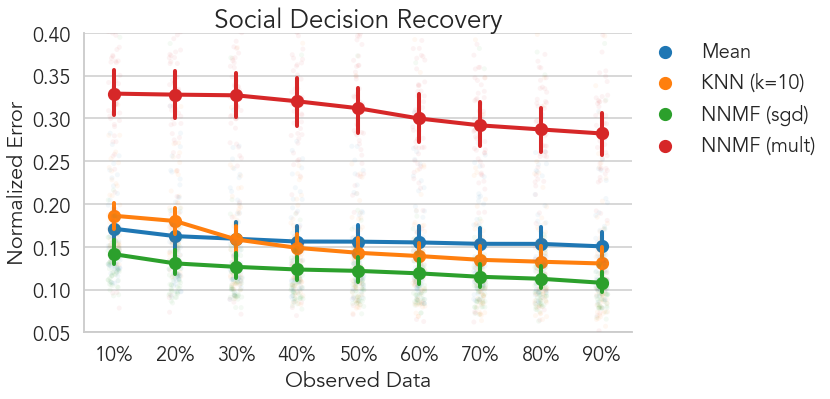

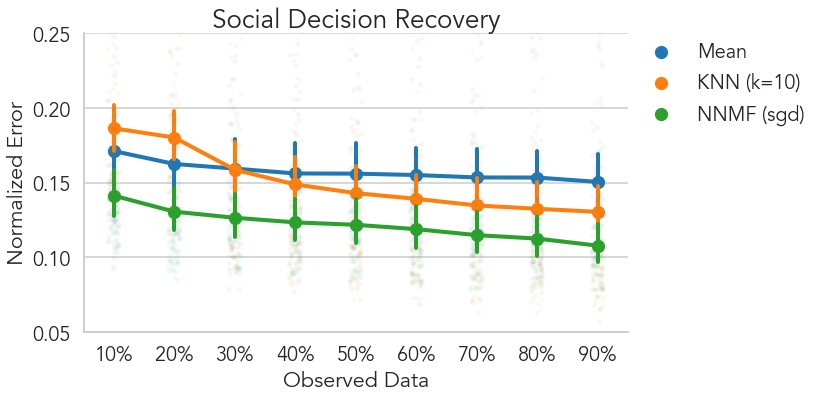

In [8]:
# With NNMF_mult
plot_overall_results(
    decisions_plot,
    title="Social Decision Recovery",
    hide_nmf_m=False,
    save=fig_dir / "decisions" / "overall",
    alpha=0.05,
    ylim=(0.05, 0.4),
)
# Without NNMF_mult
plot_overall_results(
    decisions_plot,
    title="Social Decision Recovery",
    hide_nmf_m=True,
    save=fig_dir / "decisions" / "overall_no_m",
    alpha=0.05,
    ylim=(0.05, 0.25),
)

## Regression comparisons

In [47]:
decisions_plot_filtered = decisions_plot.query(
    "algorithm != 'NNMF (mult)' and dilation == 0 and n_factors == 'all'"
).reset_index(drop=True)
model = Lmer("score ~ algorithm*Samples_Perc + (1|user)", data=decisions_plot_filtered)
model.fit(
    factors={
        "algorithm": ["Mean", "KNN (k=10)", "NNMF (sgd)"],
        "Samples_Perc": ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"],
    },
    summary=False,
)
# No p-val correction here because we'll do it manually below
marginals, contrasts = model.post_hoc(
    marginal_vars="algorithm", grouping_vars="Samples_Perc", p_adjust="none"
)

P-values adjusted by none method for 3 comparisons


In [48]:
# Only make orthogonal comparisons against Mean and adjust p-values using bonferroni correction
decisions_con_adjusted = (
    contrasts.query("Contrast != 'KNN (k=10) - NNMF (sgd)'")
    .assign(
        P_val_adj=lambda df: df["P-val"].apply(lambda x: x * 9),
        Sig=lambda df: df["P_val_adj"].apply(_sig_stars),
    )
    .drop(columns=["P-val"])
)
decisions_con_adjusted

Contrast Samples_Perc  Estimate  2.5_ci  97.5_ci     SE      DF  \
0   Mean - KNN (k=10)          10%    -0.015  -0.024   -0.006  0.005  1534.0   
1   Mean - NNMF (sgd)          10%     0.030   0.021    0.039  0.005  1534.0   
3   Mean - KNN (k=10)          20%    -0.018  -0.027   -0.008  0.005  1534.0   
4   Mean - NNMF (sgd)          20%     0.032   0.023    0.041  0.005  1534.0   
6   Mean - KNN (k=10)          30%     0.001  -0.008    0.010  0.005  1534.0   
7   Mean - NNMF (sgd)          30%     0.033   0.024    0.042  0.005  1534.0   
9   Mean - KNN (k=10)          40%     0.007  -0.002    0.017  0.005  1534.0   
10  Mean - NNMF (sgd)          40%     0.033   0.023    0.042  0.005  1534.0   
12  Mean - KNN (k=10)          50%     0.013   0.004    0.022  0.005  1534.0   
13  Mean - NNMF (sgd)          50%     0.034   0.025    0.043  0.005  1534.0   
15  Mean - KNN (k=10)          60%     0.016   0.007    0.025  0.005  1534.0   
16  Mean - NNMF (sgd)          60%     0.036   0.027    0.045  0.005  1534.0   
18  Mean - KNN (k=10)          70%     0.019   0.009    0.028  0.005  1534.0   
19  Mean - NNMF (sgd)          70%     0.039   0.029    0.048  0.005  1534.0   
21  Mean - KNN (k=10)          80%     0.021   0.012    0.030  0.005  1534.0   
22  Mean - NNMF (sgd)          80%     0.041   0.032    0.050  0.005  1534.0   
24  Mean - KNN (k=10)          90%     0.020   0.011    0.029  0.005  1534.0   
25  Mean - NNMF (sgd)          90%     0.043   0.033    0.052  0.005  1534.0   

    T-stat  Sig  P_val_adj  
0   -3.229   **      0.009  
1    6.323  ***      0.000  
3   -3.755  ***      0.000  
4    6.770  ***      0.000  
6    0.164           7.830  
7    6.978  ***      0.000  
9    1.564           1.062  
10   6.943  ***      0.000  
12   2.768    .      0.054  
13   7.262  ***      0.000  
15   3.383   **      0.009  
16   7.681  ***      0.000  
18   3.973  ***      0.000  
19   8.186  ***      0.000  
21   4.432  ***      0.000  
22   8.664  ***      0.000  
24   4.252  ***      0.000  
25   9.046  ***      0.000

## By phenotype

In [49]:
true_cluster_labels = {
    "IA": [
        128,
        132,
        133,
        138,
        140,
        141,
        143,
        144,
        145,
        150,
        151,
        152,
        153,
        157,
        165,
        172,
        175,
        178,
        179,
        181,
        183,
        190,
        191,
        192,
    ],
    "GA": [142, 146, 154, 158, 186],
    "GR": [124, 136, 148, 159, 160, 182, 184],
    "MO": [
        126,
        129,
        130,
        131,
        134,
        135,
        137,
        139,
        156,
        161,
        162,
        164,
        171,
        173,
        174,
        176,
        177,
        180,
        185,
        187,
        189,
    ],
}

# Generate a {sub: cluster} map
user_map = {}
for k, v in true_cluster_labels.items():
    for user in v:
        user_map[user] = k

In [50]:
# Add cluster labels to df
decisions_user_plot_filtered = decisions_plot[decisions_plot.user.isin(user_map.keys())].copy()
decisions_user_plot_filtered["phenotype"] = decisions_user_plot_filtered.user.map(user_map)
decisions_user_plot_filtered = decisions_user_plot_filtered.query(
    "dimension == 'Prop_Returned' and algorithm != 'NNMF (mult)' and n_factors == 'all'"
).reset_index(drop=True)

### Phenotype regression comparisons

In [ ]:
model = Lmer(
    "score ~ algorithm*Samples_Perc*phenotype + (1 | user)",
    data=decisions_user_plot_filtered,
)
model.fit(
    factors={
        "algorithm": ["Mean", "KNN (k=10)", "NNMF (sgd)"],
        "Samples_Perc": ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"],
        "phenotype": ["GR", "GA", "MO", "IA"],
    },
    ordered=True,
    summary=False,
)
model.anova(force_orthogonal=True)
marginals, comparisons = model.post_hoc(
    marginal_vars="algorithm",
    grouping_vars=["phenotype", "Samples_Perc"],
    p_adjust="bonf",
)

In [56]:
marginals.query("algorithm == 'Mean'").sort_values(by=["Samples_Perc", "Estimate"])

algorithm phenotype Samples_Perc  Estimate  2.5_ci  97.5_ci     SE  \
7        Mean        IA          10%     0.142   0.130    0.155  0.006   
10       Mean        MO          10%     0.148   0.135    0.162  0.007   
1        Mean        GA          10%     0.201   0.173    0.229  0.014   
4        Mean        GR          10%     0.241   0.217    0.265  0.012   
19       Mean        IA          20%     0.133   0.120    0.146  0.006   
22       Mean        MO          20%     0.138   0.125    0.152  0.007   
13       Mean        GA          20%     0.195   0.167    0.223  0.014   
16       Mean        GR          20%     0.238   0.214    0.261  0.012   
31       Mean        IA          30%     0.131   0.118    0.144  0.006   
34       Mean        MO          30%     0.134   0.121    0.148  0.007   
25       Mean        GA          30%     0.188   0.160    0.216  0.014   
28       Mean        GR          30%     0.236   0.212    0.259  0.012   
43       Mean        IA          40%     0.125   0.112    0.138  0.006   
46       Mean        MO          40%     0.132   0.118    0.145  0.007   
37       Mean        GA          40%     0.192   0.164    0.220  0.014   
40       Mean        GR          40%     0.235   0.212    0.259  0.012   
55       Mean        IA          50%     0.126   0.113    0.139  0.006   
58       Mean        MO          50%     0.131   0.118    0.145  0.007   
49       Mean        GA          50%     0.179   0.151    0.207  0.014   
52       Mean        GR          50%     0.237   0.213    0.261  0.012   
67       Mean        IA          60%     0.125   0.112    0.137  0.006   
70       Mean        MO          60%     0.131   0.117    0.145  0.007   
61       Mean        GA          60%     0.183   0.155    0.211  0.014   
64       Mean        GR          60%     0.237   0.213    0.260  0.012   
79       Mean        IA          70%     0.124   0.111    0.136  0.006   
82       Mean        MO          70%     0.129   0.115    0.142  0.007   
73       Mean        GA          70%     0.185   0.157    0.213  0.014   
76       Mean        GR          70%     0.232   0.208    0.256  0.012   
91       Mean        IA          80%     0.124   0.111    0.136  0.006   
94       Mean        MO          80%     0.128   0.115    0.142  0.007   
85       Mean        GA          80%     0.181   0.153    0.209  0.014   
88       Mean        GR          80%     0.232   0.208    0.256  0.012   
103      Mean        IA          90%     0.122   0.109    0.135  0.006   
106      Mean        MO          90%     0.125   0.112    0.139  0.007   
97       Mean        GA          90%     0.169   0.141    0.197  0.014   
100      Mean        GR          90%     0.233   0.209    0.256  0.012   

          DF  
7    100.159  
10   100.159  
1    100.159  
4    100.159  
19   100.159  
22   100.159  
13   100.159  
16   100.159  
31   100.159  
34   100.159  
25   100.159  
28   100.159  
43   100.159  
46   100.159  
37   100.159  
40   100.159  
55   100.159  
58   100.159  
49   100.159  
52   100.159  
67   100.159  
70   100.159  
61   100.159  
64   100.159  
79   100.159  
82   100.159  
73   100.159  
76   100.159  
91   100.159  
94   100.159  
85   100.159  
88   100.159  
103  100.159  
106  100.159  
97   100.159  
100  100.159

In [206]:
comparisons.query("Contrast == 'Mean - NNMF (sgd)'").sort_values(by=["phenotype", "Samples_Perc"])

Contrast phenotype Samples_Perc  Estimate  2.5_ci  97.5_ci  \
2    Mean - NNMF (sgd)        GA          10%     0.035   0.010    0.061   
14   Mean - NNMF (sgd)        GA          20%     0.044   0.018    0.069   
26   Mean - NNMF (sgd)        GA          30%     0.034   0.009    0.060   
38   Mean - NNMF (sgd)        GA          40%     0.044   0.018    0.069   
50   Mean - NNMF (sgd)        GA          50%     0.035   0.010    0.061   
62   Mean - NNMF (sgd)        GA          60%     0.044   0.019    0.070   
74   Mean - NNMF (sgd)        GA          70%     0.046   0.021    0.072   
86   Mean - NNMF (sgd)        GA          80%     0.054   0.029    0.080   
98   Mean - NNMF (sgd)        GA          90%     0.039   0.014    0.065   
5    Mean - NNMF (sgd)        GR          10%     0.133   0.111    0.155   
17   Mean - NNMF (sgd)        GR          20%     0.138   0.117    0.160   
29   Mean - NNMF (sgd)        GR          30%     0.140   0.118    0.162   
41   Mean - NNMF (sgd)        GR          40%     0.142   0.121    0.164   
53   Mean - NNMF (sgd)        GR          50%     0.145   0.123    0.166   
65   Mean - NNMF (sgd)        GR          60%     0.147   0.126    0.169   
77   Mean - NNMF (sgd)        GR          70%     0.144   0.123    0.166   
89   Mean - NNMF (sgd)        GR          80%     0.145   0.124    0.167   
101  Mean - NNMF (sgd)        GR          90%     0.145   0.123    0.167   
8    Mean - NNMF (sgd)        IA          10%     0.011  -0.001    0.022   
20   Mean - NNMF (sgd)        IA          20%     0.012   0.001    0.024   
32   Mean - NNMF (sgd)        IA          30%     0.016   0.004    0.028   
44   Mean - NNMF (sgd)        IA          40%     0.013   0.002    0.025   
56   Mean - NNMF (sgd)        IA          50%     0.016   0.004    0.027   
68   Mean - NNMF (sgd)        IA          60%     0.015   0.004    0.027   
80   Mean - NNMF (sgd)        IA          70%     0.018   0.006    0.030   
92   Mean - NNMF (sgd)        IA          80%     0.021   0.010    0.033   
104  Mean - NNMF (sgd)        IA          90%     0.025   0.013    0.036   
11   Mean - NNMF (sgd)        MO          10%     0.019   0.007    0.032   
23   Mean - NNMF (sgd)        MO          20%     0.019   0.007    0.032   
35   Mean - NNMF (sgd)        MO          30%     0.019   0.007    0.031   
47   Mean - NNMF (sgd)        MO          40%     0.019   0.006    0.031   
59   Mean - NNMF (sgd)        MO          50%     0.020   0.008    0.033   
71   Mean - NNMF (sgd)        MO          60%     0.023   0.011    0.036   
83   Mean - NNMF (sgd)        MO          70%     0.025   0.012    0.037   
95   Mean - NNMF (sgd)        MO          80%     0.023   0.011    0.036   
107  Mean - NNMF (sgd)        MO          90%     0.028   0.016    0.041   

        SE        DF  T-stat  P-val  Sig  
2    0.011  1377.999   3.312  0.003   **  
14   0.011  1377.999   4.090  0.000  ***  
26   0.011  1377.999   3.214  0.004   **  
38   0.011  1377.999   4.109  0.000  ***  
50   0.011  1377.999   3.289  0.003   **  
62   0.011  1377.999   4.178  0.000  ***  
74   0.011  1377.999   4.359  0.000  ***  
86   0.011  1377.999   5.113  0.000  ***  
98   0.011  1377.999   3.704  0.001  ***  
5    0.009  1377.999  14.783  0.000  ***  
17   0.009  1377.999  15.374  0.000  ***  
29   0.009  1377.999  15.555  0.000  ***  
41   0.009  1377.999  15.818  0.000  ***  
53   0.009  1377.999  16.080  0.000  ***  
65   0.009  1377.999  16.367  0.000  ***  
77   0.009  1377.999  16.031  0.000  ***  
89   0.009  1377.999  16.134  0.000  ***  
101  0.009  1377.999  16.106  0.000  ***  
8    0.005  1377.999   2.192  0.086    .  
20   0.005  1377.999   2.564  0.031    *  
32   0.005  1377.999   3.287  0.003   **  
44   0.005  1377.999   2.712  0.020    *  
56   0.005  1377.999   3.243  0.004   **  
68   0.005  1377.999   3.136  0.005   **  
80   0.005  1377.999   3.729  0.001  ***  
92   0.005  1377.999   4.384  0.000  ***  
104  0.005  1377.999   5.082  0.000  ***

In [205]:
comparisons.query("Contrast == 'KNN (k=10) - Mean'").sort_values(by=["phenotype", "Samples_Perc"])

Contrast phenotype Samples_Perc  Estimate  2.5_ci  97.5_ci  \
0    KNN (k=10) - Mean        GA          10%     0.011  -0.015    0.036   
12   KNN (k=10) - Mean        GA          20%     0.009  -0.016    0.035   
24   KNN (k=10) - Mean        GA          30%    -0.015  -0.041    0.010   
36   KNN (k=10) - Mean        GA          40%    -0.033  -0.059   -0.008   
48   KNN (k=10) - Mean        GA          50%    -0.025  -0.051    0.000   
60   KNN (k=10) - Mean        GA          60%    -0.037  -0.062   -0.011   
72   KNN (k=10) - Mean        GA          70%    -0.055  -0.081   -0.030   
84   KNN (k=10) - Mean        GA          80%    -0.051  -0.076   -0.025   
96   KNN (k=10) - Mean        GA          90%    -0.057  -0.083   -0.032   
3    KNN (k=10) - Mean        GR          10%     0.009  -0.013    0.030   
15   KNN (k=10) - Mean        GR          20%     0.008  -0.013    0.030   
27   KNN (k=10) - Mean        GR          30%    -0.007  -0.029    0.014   
39   KNN (k=10) - Mean        GR          40%    -0.009  -0.030    0.013   
51   KNN (k=10) - Mean        GR          50%    -0.012  -0.033    0.010   
63   KNN (k=10) - Mean        GR          60%    -0.010  -0.032    0.011   
75   KNN (k=10) - Mean        GR          70%    -0.010  -0.031    0.012   
87   KNN (k=10) - Mean        GR          80%    -0.005  -0.027    0.016   
99   KNN (k=10) - Mean        GR          90%    -0.002  -0.024    0.020   
6    KNN (k=10) - Mean        IA          10%     0.019   0.007    0.031   
18   KNN (k=10) - Mean        IA          20%     0.018   0.006    0.029   
30   KNN (k=10) - Mean        IA          30%    -0.003  -0.015    0.009   
42   KNN (k=10) - Mean        IA          40%    -0.006  -0.018    0.005   
54   KNN (k=10) - Mean        IA          50%    -0.014  -0.026   -0.002   
66   KNN (k=10) - Mean        IA          60%    -0.017  -0.028   -0.005   
78   KNN (k=10) - Mean        IA          70%    -0.018  -0.030   -0.007   
90   KNN (k=10) - Mean        IA          80%    -0.021  -0.033   -0.010   
102  KNN (k=10) - Mean        IA          90%    -0.023  -0.034   -0.011   
9    KNN (k=10) - Mean        MO          10%     0.016   0.003    0.028   
21   KNN (k=10) - Mean        MO          20%     0.023   0.011    0.036   
33   KNN (k=10) - Mean        MO          30%     0.008  -0.004    0.021   
45   KNN (k=10) - Mean        MO          40%    -0.001  -0.014    0.011   
57   KNN (k=10) - Mean        MO          50%    -0.007  -0.019    0.006   
69   KNN (k=10) - Mean        MO          60%    -0.011  -0.023    0.002   
81   KNN (k=10) - Mean        MO          70%    -0.012  -0.024    0.001   
93   KNN (k=10) - Mean        MO          80%    -0.018  -0.030   -0.005   
105  KNN (k=10) - Mean        MO          90%    -0.012  -0.024    0.001   

        SE        DF  T-stat  P-val  Sig  
0    0.011  1377.999   1.011  0.937       
12   0.011  1377.999   0.891  1.000       
24   0.011  1377.999  -1.434  0.456       
36   0.011  1377.999  -3.102  0.006   **  
48   0.011  1377.999  -2.381  0.052    .  
60   0.011  1377.999  -3.469  0.002   **  
72   0.011  1377.999  -5.192  0.000  ***  
84   0.011  1377.999  -4.784  0.000  ***  
96   0.011  1377.999  -5.375  0.000  ***  
3    0.009  1377.999   0.974  0.991       
15   0.009  1377.999   0.926  1.000       
27   0.009  1377.999  -0.817  1.000       
39   0.009  1377.999  -0.949  1.000       
51   0.009  1377.999  -1.304  0.578       
63   0.009  1377.999  -1.162  0.736       
75   0.009  1377.999  -1.090  0.828       
87   0.009  1377.999  -0.604  1.000       
99   0.009  1377.999  -0.224  1.000       
6    0.005  1377.999   3.916  0.000  ***  
18   0.005  1377.999   3.638  0.001  ***  
30   0.005  1377.999  -0.592  1.000       
42   0.005  1377.999  -1.295  0.587       
54   0.005  1377.999  -2.876  0.012    *  
66   0.005  1377.999  -3.398  0.002   **  
78   0.005  1377.999  -3.736  0.001  ***  
90   0.005  1377.999  -4.396  0.000  ***  
102  0.005  1377.999  -4.642  0.000  ***

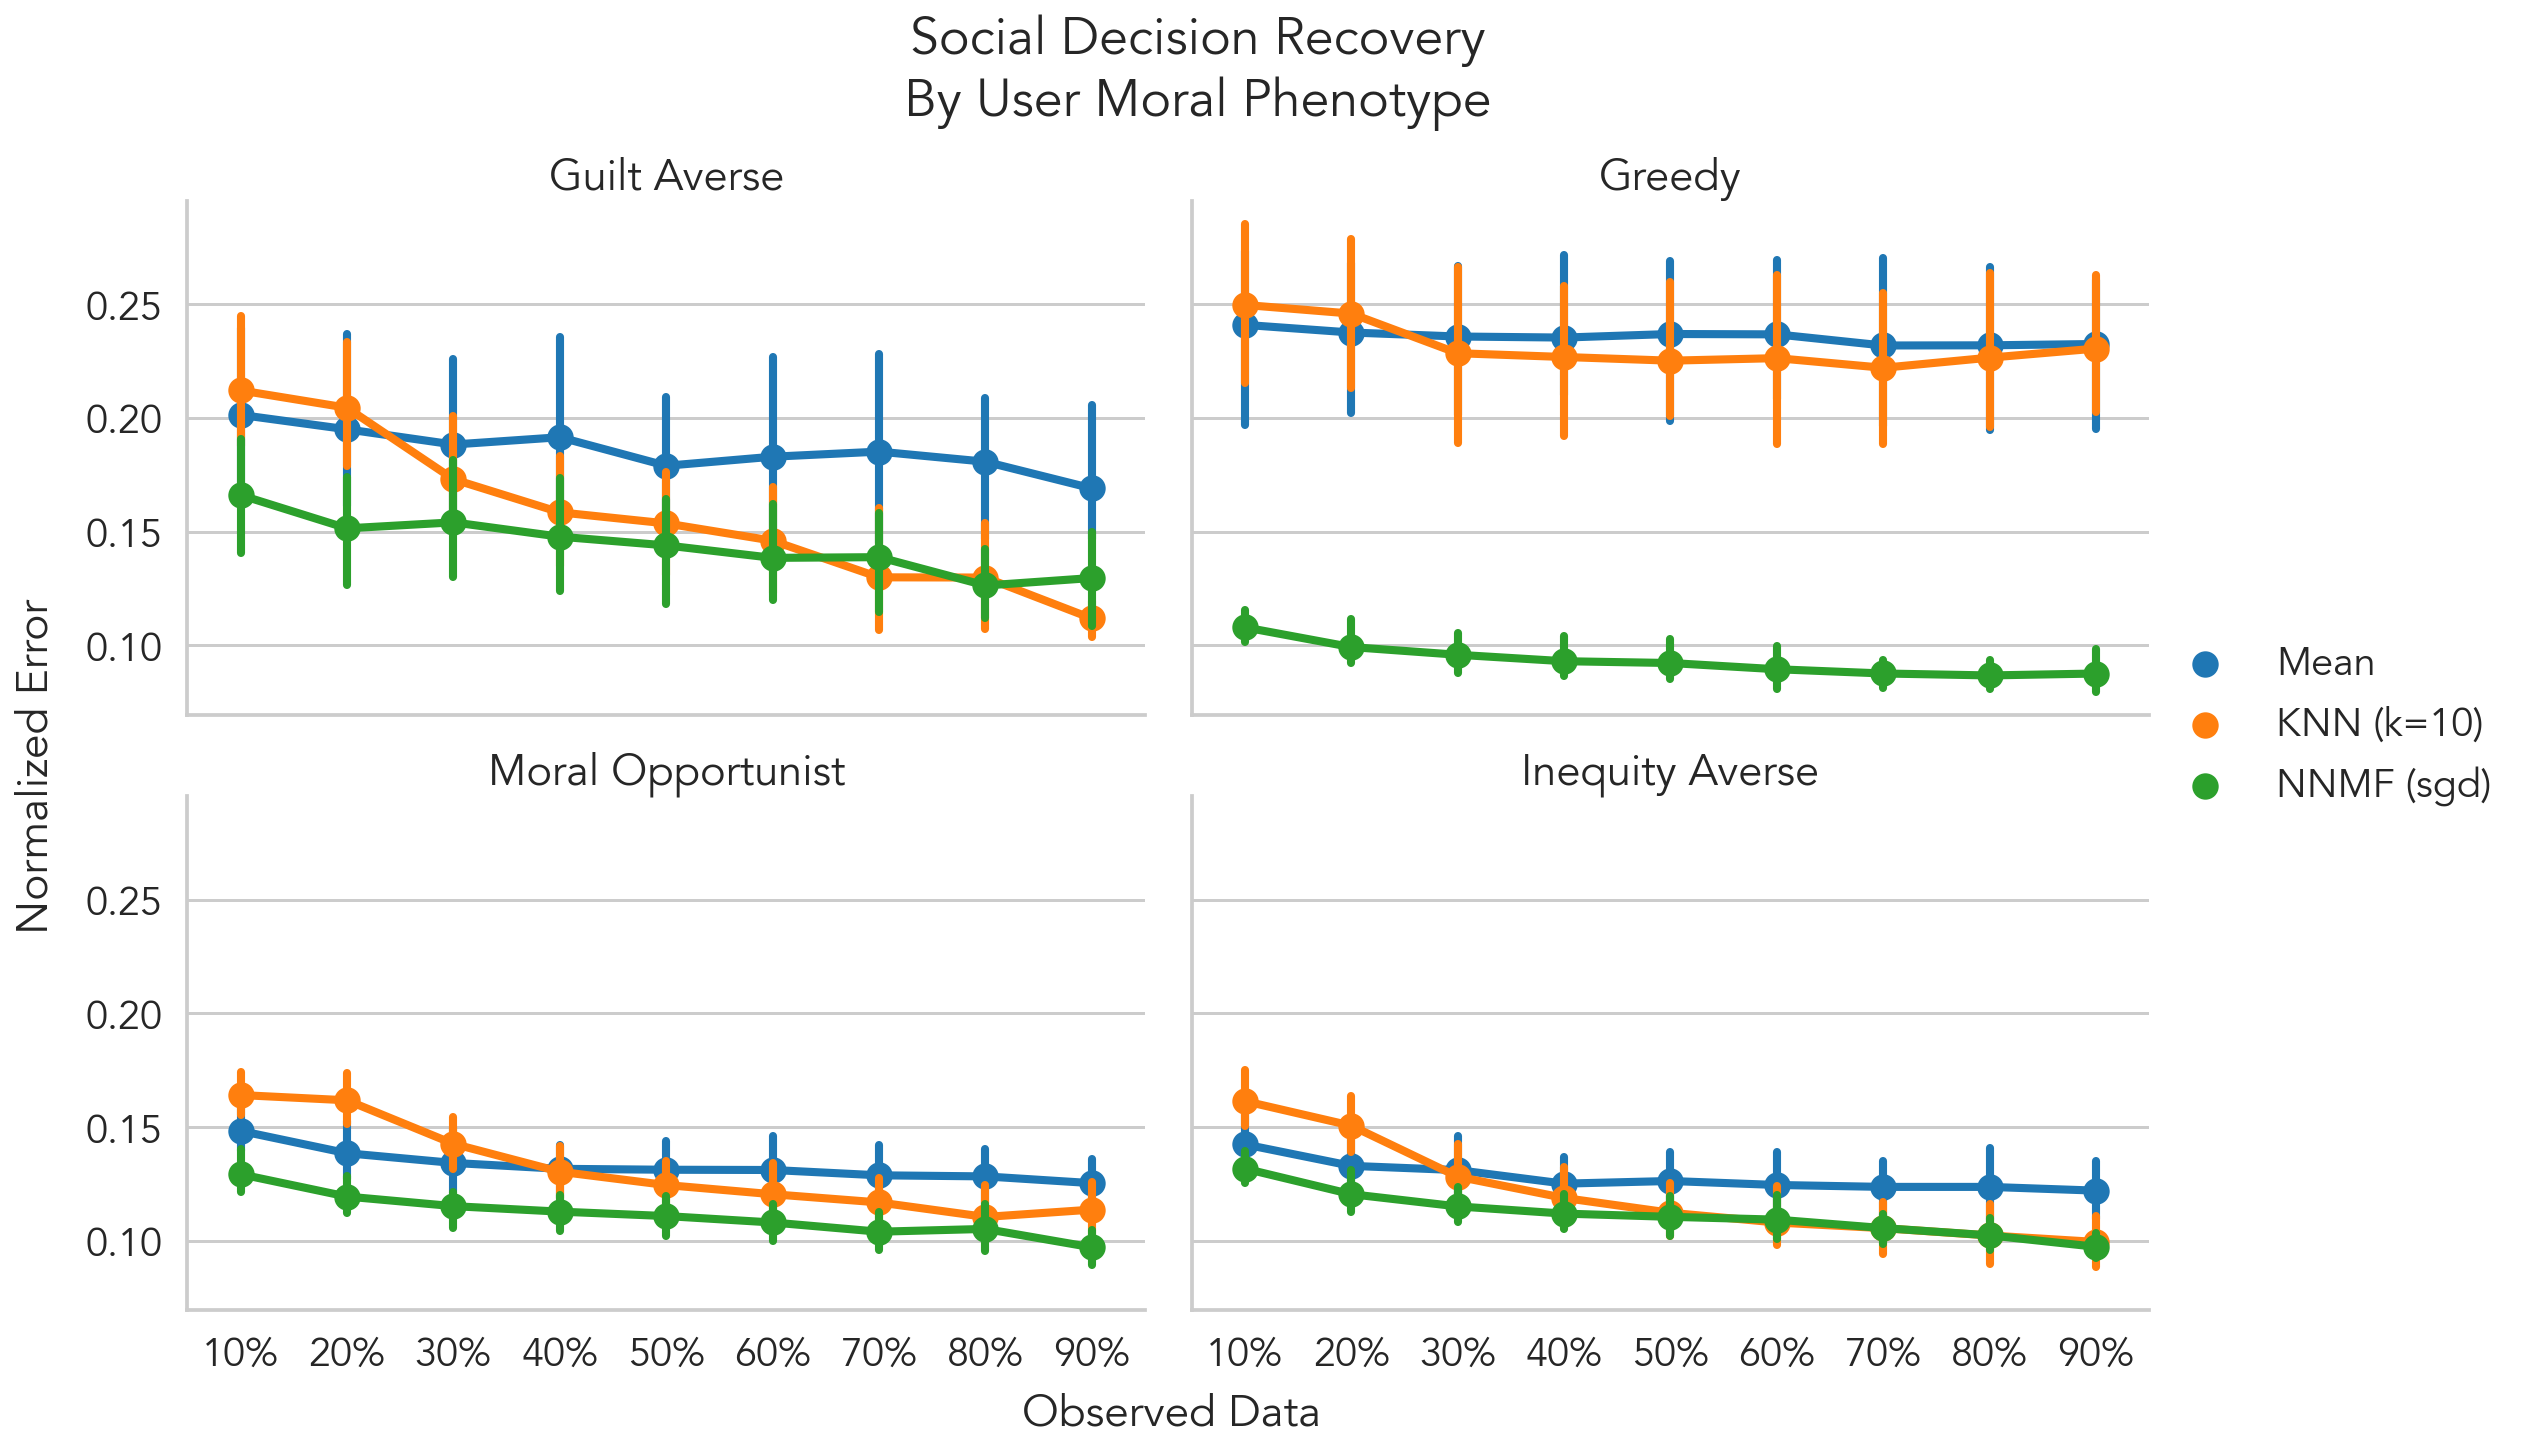

In [128]:
decisions_user_plot_filtered["phenotype"] = decisions_user_plot_filtered.phenotype.map(
    {"GA": "Guilt Averse", "GR": "Greedy", "MO": "Moral Opportunist", "IA": "Inequity Averse"}
)
plot_results(
    decisions_user_plot_filtered,
    "decisions",
    df_type="user",
    n_boot=100,
    title="Social Decision Recovery\nBy User Moral Phenotype",
    title_padding=0.85,
    ylabel="Normalized Error",
    col="phenotype",
    col_wrap=2,
    hide_nmf_m=True,
    average_marginals=False,
    save=fig_dir / "decisions" / "by_phenotype_norm",
)